# Report

**Please complete the written portion of your report in the next cell after finishing the coding part of the assignment. Grader will review the report and the figures in the following cells to grade this report section.**






**Traditional Approach:**

Training recognition rate:    **0.4868**

Testing recognition rate 1:   **0.1571**

Testing recognition rate 2:   **0.5125**

**Guassian filter Approach:**
As this images have more noise .Through gaussian filter approach its easier to remove noise efficiently.we can see the improvement rates

In this Approach in the process function before binarizing the image we have used a gaussian filter with kernel size=(5,5).Have tried using different kernel size such as 3 and 7 but it did not yield in improvement,same with standard deviation in x and y =0,0 used but tried different values which did not give satisfactory results and then we binarized the image and the rest follows 

Training recognition rate:    **0.5194**

Testing recognition rate 1:    **0.2714**

Testing recognition rate 2:    **0.5375**

**Decision Tree Approach:**
In this approach we have used decision tree to train the data and fit the data and predict the data in the training module.we can see the improvements below its a exact fit for training but we can see the testing rate 2 has dropped

Training recognition rate:   **1.0**

Testing recognition rate 1:  **0.3428**

Testing recognition rate 2:  **0.4375**

**Combined Approach of Guassian and Decision Tree Approach :**
I have combined the first and second approach which is the guassian filter and decision tree together for improved results which we  used to get efficient results we can see below it shows the best improvement results

Training recognition rate:    **1.0**

Testing recognition rate 1:   **0.4857**

Testing recognition rate 2:      **0.5375**



# Installation

Please install the required packages if you're running this notebook on Colab. You'll also need to upload the `Assignment1materials.zip` file to the Colab folder and uncompress it. Keep in mind that you may need to repeat the installation and uploading process for every new Colab session.

In [ ]:
# remove the comment if in colab
!pip install numpy scikit-learn scipy scikit-image matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you are running this notebook locally on your own machine, you can install these packages using either of the the following two commands:
Option 1:
```bash
pip install numpy scikit-learn scipy scikit-image matplotlib
```
Option 2:
```bash
conda install numpy scikit-learn scipy scikit-image matplotlib
```

# Introduction

This assignment is supposed to be a tutorial assignment that will lead you step by step to use Python 3 and built-in functions from several Python libraries to build an optical character recognition (OCR) system for hand-written characters, as a practice on binary image analysis. 

![](https://i.imgur.com/CT604h7.png)

## Problem Overview

In this assignment you will be given grayscale images of hand-written characters, where you will need to **identify** (extract) and **recognize** (classify) each character. 

The assignment has two phases: Training and recognition. After completing these, you will be asked to improve your recognition rates by providing your own ideas, which is the enhancement part. 

For both training and recognition, you will need to convert the grayscale images to binary images, identify each separate character instance appearing in the image and extract some visual features from these character instances. 

In the training phase, you will build (learn) a ‘database’ of features that you extracted from a given set of character images. These features will be put inside a matrix that will be later used as a recognition database. At this phase you will know what each character is (its label) and you will also store this information along with the extracted features.

In the recognition phase, you will use the built database of features, the associated character labels and the features you extracted from your test image to recognize each character in this test image. Features extracted for each character instance in the test image will be compared to all the features in the database and the label of the ‘best’ matching character instance in the database will be the recognition result for this test character instance (this is called nearest neighbor classifier). 

For crosscheck you will also be performing the same recognition step for the training images and measure the how well you have performed. This way you will know if your features are descriptive enough for your characters and you will also have the chance to catch possible errors in your implementation earlier.

## Given Files

There are several images and code files we supplied with the assignment.

### Images

**Training Image Set:** You are given a set of 16 images (‘a.bmp’, ‘d.bmp’,… , ‘z.bmp’), each with different instances of one character in it. Images can be of different sizes. 

Following is part of the training image ‘a.jpg’

<img src="https://i.imgur.com/9wEvjDS.png" width=100>

**Test Image:** You are also given two test images for evaluation (‘test1’, ‘test2’), which contains different instances of the hand-written characters in the training set, combined in one image.

<img src="https://i.imgur.com/KD10soZ.png" width=100>

# Implementation

## Training

### Importing necessary Python modules and define visualize function

The following modules contain functions that you need to use for this assignment.

In [ ]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import seaborn as sns
from typing import List, Tuple

def visualize(img, title="", enlarge=False):
    if enlarge:
        plt.figure(figsize=(8,8), dpi=120)
    io.imshow(img)
    if title != "":
        plt.title(title)
    io.show()

### Reading Images and Binarization

**Reading an Image File**

We can read an image file into a matrix using the function `io.imread()`. For example, to open the image with character ‘a’ use:

In [ ]:
materials_path = "/content/drive/MyDrive/Assignment1materials" # path to point to your Assignment1materials folder
images_path = f"{materials_path}/images"
img = io.imread(f'{images_path}/a.bmp')

Now, the variable img contains the image as a matrix. Check out the size of the image using:

In [ ]:
print(img.shape)

(750, 600)


The result will be (image_height, image_weight) (e.g., (750, 600)).

**Visualizing an Image/Matrix**

We can visualize the loaded image by `io.imshow()` followed by `io.show()`:

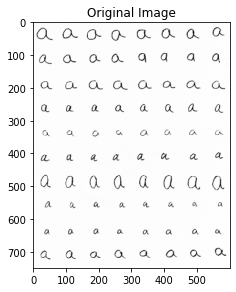

In [ ]:
visualize(img, 'Original Image')

Note that simply calling io.imshow(img) won’t show anything, until a call to io.show() is made.

**Image Histogram**

Now we will look into the histogram of the image pixel intensities:

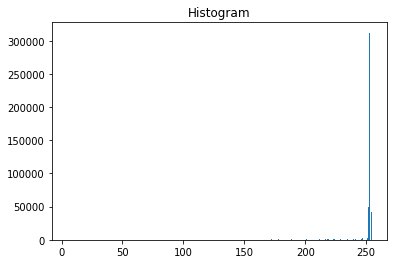

In [ ]:
hist = exposure.histogram(img)
plt.bar(hist[1], hist[0])
plt.title('Histogram')
plt.show()

You should see most of the image intensities are concentrated at a large value (~250). This is expected since the image background is mostly white.

**Binarization by Thresholding**

Given this histogram we can choose a threshold to obtain binary image from the grayscale image (binarize the image). It is up to you to choose a suitable threshold. You can try different values and see the effect on the resulting binary image. To do this, first we define a variable called th for the threshold and set it to a certain value, say 200. Then, we use logical operation to find intensity values greater (smaller) than th and assign these pixels to 0 (1). 

In [ ]:
th = 200
img_binary = (img < th).astype(np.double)

**Displaying Binary Image**

Similarly with above, we can visualize the binary image by

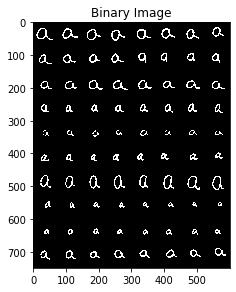

In [ ]:
visualize(img_binary, 'Binary Image')

### Extracting Characters and Their Features

**Connected Component Analysis**

Given the binary image we have, we can now run connected component analysis to label each character with a unique label. To do this, we can use the `label()` function, which performs connected component analysis on the image and return a labeled image where all the pixels in each component are given an integer label 0, 1, 2,... where 0 is the background.

In [ ]:
img_label = label(img_binary, background=0)

You can visualize the resulting component image:

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


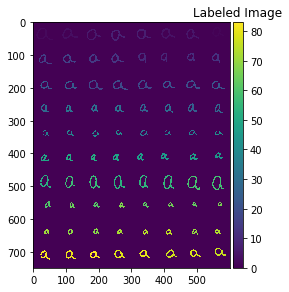

In [ ]:
visualize(img_label, 'Labeled Image')

In this figure each component has a different color since it has a different label. To find out how many connected components are in the image, you can find the maximum label value appearing in the labeled image using:

In [ ]:
print(np.amax(img_label))

83


You can see the number of components is a little more than the number of characters in the page. This is due to small isolated components that are mainly noise. Usually this is called salt and pepper noise. This can be removed using mathematical morphology. Or you can try to omit small size components from further analysis by simply comparing their height and width to certain threshold.

Following is a sample character instance from character ‘o’ and its thresholded version. You can see the small component that will be identified as another letter instance in the labeling process and thus has to be removed before feature extraction. 

![](https://i.imgur.com/Yh0icZ0.png)

**Displaying Component Bounding Boxes**

For each component you can find out and visualize the bounding box containing it using the following piece of code that loops through the components and find the maximum and minimum of their coordinates:

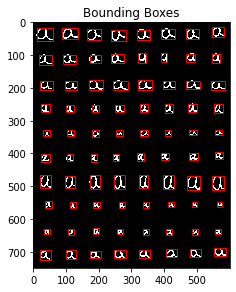

In [ ]:
regions = regionprops(img_label)
io.imshow(img_binary)
ax = plt.gca()
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor = 'red', linewidth = 1))
ax.set_title('Bounding Boxes')
io.show()

Note that `regionprops()` returns all connected components in a list, where each element contains a set of properties for each component. Details about this function can be found here:
http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops.

**Computing Hu Moments and Removing Small Components**

In this step we will compute the Hu moments and other statistical measures for each character. For each bounding box `props.bbox`, we get the corner coordinates (minr, minc, maxr, maxc) as shown above, then we do this:

In [ ]:
roi = img_binary[minr:maxr, minc:maxc]
m = moments(roi)
cc = m[0, 1] / m[0, 0]
cr = m[1, 0] / m[0, 0]
center = (cr, cc)
mu = moments_central(roi, center)
nu = moments_normalized(mu)
hu = moments_hu(nu)

All you need to do is to insert these lines into the previous loop at a proper position.

It would be useful to omit small size noise components as mentioned above before calling the moment function. Just add an ‘if’ statement to compare components height and width with a given size threshold, and ignore those components that are too small. Experiment and visualize your bounding boxes until you find a good size threshold.

**Storing Features**

The next step is to modify the above code in order to store the resulting features for each character to be used in recognition. To do this, simply create an empty list before the loop, let's call it 'Features_List' using:

```python
Features_List=[]
```

Then, inside the loop you need to concatenate each character features to the existing feature list. At the end, 'Features' will contain one row for each character with 7 features in each row (7 dimensions of Hu moments). The concatenation can be done using:

```python
Features_List.append(hu)
```

### Building Character Features Database for Recognition

**Creating function `process` and `process_training_data` to process all images**

Now that we have extracted features for one image, the final part of training phase is to extract the features for all the characters in all the images given to you to create a database of character features to be used in recognition.

In this section, you are required to implement two functions to process all the character images. The goal is to extract features for all characters from all images and put them into one big features list as above. The interfaces and function definitions have been provided. Please follow the instructions to complete the implementation.

Please write the implementation for the `process` function in the following cell. The function should perform the following operations on an input image:

1. Read the image
2. Plot the histogram of the image
3. Binarize the image using a threshold
4. Label the connected components in the binarized image
5. Extract the components and add their bounding boxes to an output list
6. Compute the Hu Moments of each component and add them to an output list
7. Plot the image with the bounding boxes

The function should return a list containing:

1. img_label: the labeled image
2. bounding_box_list: a list of bounding boxes for each component

##### **You should replace the `pass` statement with your own code and leave the blocks intact.**

In [ ]:
# Processes one image, and adds the features of each character (bounding box) to the features list. 
# This function returns a list of size 2.
#   index 0 -> the img_label image with the connected components.
#   index 1 -> the bounding boxes that contain characters.
# img_name          <- Input: Name of the image to process
# features_list     <- Output: Features for each character are added to this list
# show_plots        <- Input: Boolean to specify whether plots are printed
# binary_threshold  <- Input: Specifies the threshold for binarizing the image
# min_bbox_height   <- Input: Specifies the minimum height of a bounding box
# min_bbox_width    <- Input: Specifies the minimum width of a bounding box
# Returns [img_label, [bounding  boxes]]. 
def process(img_name, features_list,
            show_plots=True, binary_threshold=200, 
            min_bbox_height=10, min_bbox_width=10):

    # Read the image
    img = None
    
    # YOUR CODE HERE
    img = io.imread(f'{images_path}/{img_name}')

    # Visualize read image
    if show_plots:
        visualize(img, 'Original Image')

    # Visualize the histogram
    if show_plots:
        # YOUR CODE HERE
        hist = exposure.histogram(img)
        plt.bar(hist[1], hist[0])
        plt.title('Histogram')
        plt.show()

    # Binarize the image
    img_binary = None
    # YOUR CODE HERE
    img_binary = (img < binary_threshold).astype(np.double)
    
    # Visualize the binary image
    if show_plots:
        # YOUR CODE HERE
        visualize(img_binary, 'Binary Image')

    # Labelling connected components
    img_label = None
    # YOUR CODE HERE
    img_label = label(img_binary, background=0)
    
    # Visualize the labeled image
    if show_plots:
        # YOUR CODE HERE
        visualize(img_label,'labelled image')

    # Extracting components
    regions = regionprops(img_label)
    count_features = 0
    bounding_box_list = list()
    
    # YOUR CODE HERE
    count_features=np.amax(img_label)
    regions = regionprops(img_label)
    for props in regions:
      minr, minc, maxr, maxc = props.bbox
      if ((maxc - minc < min_bbox_width) or (maxr - minr < min_bbox_height)):
            continue
      bounding_box_list.append(props.bbox)
      roi = img_binary[minr:maxr, minc:maxc]
      m = moments(roi)
      cc = m[0, 1] / m[0, 0]
      cr = m[1, 0] / m[0, 0]
      center = (cr, cc)
      mu = moments_central(roi, center)
      nu = moments_normalized(mu)
      hu = moments_hu(nu)
      features_list.append(hu)


    
    
    # Visualize the binary image with boxes
    if show_plots:
        # YOUR CODE HERE
        io.imshow(img_binary)
        ax = plt.gca()
        for props in regions:
          minr, minc, maxr, maxc = props.bbox
          ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor = 'red', linewidth = 1))
        ax.set_title('Bounding Boxes')
        io.show()

    return [img_label, bounding_box_list]

In [ ]:

Features_List = []

image_region_info = process('a.bmp', Features_List, show_plots=False, 
                            binary_threshold=200, min_bbox_height=10, min_bbox_width=10)
assert len(image_region_info) == 2

In the following cell, you are required to implement the `process_training_data` function. `process_training_data` uses the `process` function your implemented to process all 10 training images.

The function should return a list containing:

1. Tuples of img_label and bounding_box_list from the output of function `process` for each image.

##### **You should replace the `pass` statement with your own code and leave the blocks intact.**

In [ ]:
# Processes all the training data, building the features_database and a corresponing class_label_list
# features_database <- Output: A list of the features for every character in every image go here
# class_label_list  <- Output: Each row in the features database has a corresponding class label
# images            <- Input: List of images to process, given by name
# classes           <- Input: List of character classes, corresponding to the list of images
# show_plots        <- Input: Boolean to specify whether plots are printed
# binary_threshold  <- Input: Specifies the threshold for binarizing the image
# min_bbox_height   <- Input: Specifies the minimum height of a bounding box
# min_bbox_width    <- Input: Specifies the minimum width of a bounding box
# Returns a 10 x 2 list.
#   Column 0 contains the img_label of the image.
#   Column 1 contains a list of bounding boxes for that image. 

def process_training_data(features_database, class_label_list,
                          images = ['a.bmp', 'd.bmp', 'f.bmp', 'h.bmp', 'k.bmp', 'm.bmp', 'n.bmp', 'o.bmp', 'p.bmp', 'q.bmp', 'r.bmp', 's.bmp', 'u.bmp', 'w.bmp', 'x.bmp', 'z.bmp'],
                          classes = ['a', 'd', 'f', 'h', 'k', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'w', 'x', 'z'],
                          show_plots=True, binary_threshold=200, min_bbox_height=10, min_bbox_width=10):
    region_info = list()
    
    for image, image_class in zip(images, classes):
        # Process an individual image using the `process` function
        image_region_info = None
        image_region_info = process(image, features_database, show_plots, 
                            binary_threshold, min_bbox_height, min_bbox_width)
        region_info.append(image_region_info)
        
        # Since the number of characters detected is unknown, we need to update the class_label_list
        # until we have a class_label for every feature row. 
        while len(class_label_list) < len(features_database):
            class_label_list.append(image_class)
        
        # Assert that each row in the features database has a corresponding class label
        assert(len(features_database) == len(class_label_list))
    
    return region_info


In [ ]:

Features_List = []
Classes_List = []

region_info = process_training_data(Features_List, Classes_List, show_plots=False, binary_threshold=205)

assert len(region_info) == 16


**Normalization**

Once you create the big Features list and the corresponding class labels you are ready to do recognition. In this project we will just use a simple nearest neighbor approach to find the closest character in the database for a given test character.

One problem is that different features have different ranges, so that a large numerical difference in a feature with high variability may swamp the effects of smaller, but perhaps more significant differences in features that have very small variability. The standard solution is to transform all of the feature distributions to a standard distribution with **0 mean** and **variance of 1.0**.  This is done by first computing the mean and standard deviation of all the features (this is done over the entire set of training characters and not for one character type at a time), and then normalizing the features by subtracting the mean and dividing by the standard deviation on each feature. It would be nice to store these means and variances so that you can reuse them in the testing (recognition) phase. 


In [ ]:
Features_List = []
Classes_List  = []

# Build the features database
process_training_data(Features_List, Classes_List, show_plots=False, binary_threshold=205)

Features_Array = np.array(Features_List)
Classes_Array  = np.array(Classes_List)
print(len(Features_Array), len(Classes_Array))

# Normalize each set of features. Note that we need to normalize each column separately. 
ft_means = np.mean(Features_Array, axis=0)
ft_sds   = np.std(Features_Array, axis=0)
Normalized_Features = (Features_Array - ft_means) / ft_sds
print(np.mean(Normalized_Features[:,0]), np.std(Normalized_Features[:,0]))

1290 1290
2.671420363129059e-16 1.0000000000000004


**Recognition on Training Data**

To evaluate the performance on the training data you can find the nearest neighbor for each character in the training data and check if its class matches the correct class. Since the particular character instance itself was in the training, its feature vector will also be in the feature database and definitely this will be the closest feature vector (with distance zero). For the case of recognition on the training data we will need to find the second closest row to the feature vector we are looking for. Hopefully, the next best match will correspond to another instance of the same letter, but sometimes other letter instances can be closer. 

We will use a function provided with this assignment called cdist() which returns the **Euclidean distance** between all pairs of points. We will use it to evaluate the distance between each character and all other characters. The distance between the row vectors in the Normalized Features matrix can be found using:
```python
D = cdist(Features, Features)
```
The resulting D is an NxN matrix where N is the number of characters (number of rows of Features).

For example D(1, 5) will give you the distance between character instance 1 and character instance 5. Obviously D will have zeros on the diagonal since the distance between each character and itself is 0. To find the nearest neighbor for each character (excluding itself) you need to find the second smallest distance in each row in the D matrix. One way to do this is to sort the columns of D along each row and to find the index of the second smallest distance in each row:

```python
D_index = np.argsort(D, axis=1) 
```

The D_index matrix contains the index of the columns in D sorted according to the. The second column of D_index will contain the index of the closest match to each character (excluding itself). Find the class for this closest match by looking at the label corresponding to this instance in the label vector you constructed earlier.

**Confusion Matrix**

You can compute the confusion matrix between character classes given the built-in function 

```python
confM=confusion_matrix(Ytrue, Ypred)
```

which takes as input, the correct classes Ytrue (as a vector) and the output classes Ypred (as a vector). The confusion matrix elements will contain a normalized measure of how much each class is confused (recognized wrongly as) with another. This matrix is not necessarily symmetric, since i.e. ‘a’ can be recognized as ‘o’, but ‘o’ is recognized as ‘u’. The diagonal elements in the matrix are the cases where character classes are recognized correctly. Visualize this matrix and try to understand the reasons of very obvious confusions between several classes:

```python
io.imshow(confM)
plt.title('Confusion Matrix')
io.show()
```

**In the following cell, we provide the code for an improved visualization of the confusion matrix. Feel free to use it.**

In [ ]:
# Code given by the TA to better visualize the confusion matrix
def better_confusion_matrix(y_true, y_pred, img_title=''):
    label_set = list(set(y_true))
    label_set.sort()

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=label_set)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(img_title)
    ax.xaxis.set_ticklabels(label_set)
    ax.yaxis.set_ticklabels(label_set)
    plt.show()

In the following, we show the pipeline for recognition on training data. It includes the following steps:

1. Compute the distance matrix. This is a square (something around 800 by 800)
2. Visualize the distance matrix
3. Sort the rows in the distance matrix. Note that np.argsort returns the indexes that would sort the array, not the actual values. This is important since the index corresponds with the prediction
4. Save the first column (the correct character indexes)
5. Save the second column (the prediction indexes)
6. Associate the character indexes to an array of character classes
7. Associate the prediction indexes to an array of character classes
8. Plot the confusion matrix
9. Calculate the recognition rate on training data (crosschecking) by counting the number of times the prediction and the actual character are the same. Then divide by the total number of characters.

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


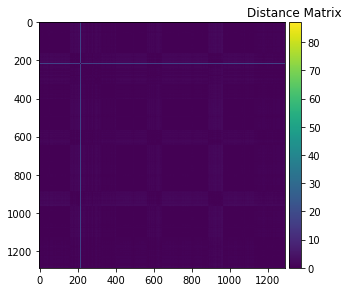

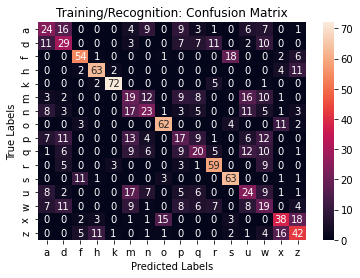

Training recognition rate: 0.4868217054263566


In [ ]:
# The Distance Matrix
distance_matrix = cdist(Normalized_Features, Normalized_Features)
visualize(distance_matrix, "Distance Matrix")

# Sort each row in the distance matrix. 
# Column 0 is the character itself
# Column 1 is the closest neighbor
sorted_rows = np.argsort(distance_matrix, axis=1)

# The first column contains the indexes of the characters themselves
first_column_indexes = sorted_rows[:, 0]

# The second column contains the indexes of the predictions
second_column_indexes = sorted_rows[:,1]


# Associate the first_column_indexes with the class labels
Ytrue = Classes_Array[first_column_indexes]

# Associate the second_column_indexes with the class labels
Ypred = Classes_Array[second_column_indexes]

# Confusion Matrix
confM = better_confusion_matrix(Ytrue, Ypred, img_title='Training/Recognition: Confusion Matrix')

# Recognition Rate on training
correct = 0
total = len(Ytrue)
for true, pred in zip(Ytrue, Ypred):
    if true == pred:
        correct += 1

recognition_rate = correct / total
print(f'Training recognition rate: {recognition_rate}')

In [ ]:
def bbox_result(img_label, bbox_list, predictions, img_title=''):
    plt.figure(figsize=(8,8), dpi=120)
    plt.imshow(img_label)
    plt.colorbar()
    ax=plt.gca()

    for bbox, pred_label in zip(bbox_list, predictions):
        min_y, min_x, max_y, max_x = bbox
        ax.add_patch(Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, fill=False, edgecolor='red', linewidth=1))

        text_x = max_x
        text_y = max_y

        ax.annotate(pred_label, xy=(text_x, text_y), xycoords='data', color='green')
  
    ax.set_title(img_title)
    io.show()

**Complete the code for training data recognition**

Please implement the `training_recognition` function for the digit recognition on the training data. The training_recognition() function does recognition on the training data using the Features array (training_db) calculated during processing. **The function draws the connected component image with bounding boxes and recognition results for all training images.**

Pipeline for recognition on training data:

1. Compute the distance matrix. This is a square (something aroung 800 by 800)
2. Visualize the distance matrix
3. Sort the rows in the distance matrix. Note that np.argsort returns the *indexes* that would sort the array, not the actual values. This is important since the index corresponds with the prediction
4. Save the first column (the correct character indexes)
5. Save the second column (the prediction indexes)
6. Associate the character indexes to an array of character classes
7. Associate the prediction indexes to an array of character classes
8. Plot the confusion matrix
9. Calculate the recognition rate on training images by counting the number of times the prediction and the actual character are the same. Then divide by the total number of characters. 


##### **You should replace the `pass` statement with your own code and leave the blocks intact.**

In [ ]:
# Perform Training / Recogition
# training_db       <- Input: The array of features calculated during processing. Not normalized.
# class_label_array <- Input: array of character names that correspond with each row in the training_db
# region_info       <- Input: List of [img_label, [bounding boxes for that image]]
def training_recognition(training_db, class_label_array, region_info):
    # Normalize the training features
    normalized_training_db = None
    # YOUR CODE HERE
    # process_training_data(training_db, class_label_array, show_plots=False, binary_threshold=205)
    training_db=np.array(training_db)
    class_label_array=np.array(class_label_array)
    ft_means = np.mean(training_db, axis=0)
    ft_sds   = np.std(training_db, axis=0)
    normalized_training_db = (training_db - ft_means) / ft_sds
    # print(len(training_db))
    
    
    # The Distance Matrix
    distance_matrix = None
    # YOUR CODE HERE
    distance_matrix = cdist(normalized_training_db, normalized_training_db)
    visualize(distance_matrix, "Training: Distance Matrix", enlarge=True)

    # Sort each row in the distance matrix.
    sorted_rows = None

    sorted_rows = np.argsort(distance_matrix, axis=1)
    
    # The first column contains the indexes of the characters themselves
    # The second column contains the indexes of the predictions
    # Associate the first_column_indexes with the class labels
    # Associate the second_column_indexes with the class labels
    first_column_indexes = None
    second_column_indexes = None
    Ytrue = None
    Ypred = None   
    
    # YOUR CODE HERE
    first_column_indexes = sorted_rows[:, 0]
    second_column_indexes = sorted_rows[:,1]
    Ytrue = class_label_array[first_column_indexes]
    Ypred=class_label_array[second_column_indexes]



    # Confusion Matrix
    confM = None
    # YOUR CODE HERE
    confM = better_confusion_matrix(Ytrue, Ypred, img_title='Training/Recognition: Confusion Matrix')

    # Recognition Rate / Crosschecking
    recognition_rate = None
    # YOUR CODE HERE
    correct = 0
    total = len(Ytrue)
    for true, pred in zip(Ytrue, Ypred):
      if true == pred:
        correct += 1

    recognition_rate = correct / total
    print(f'Training recognition rate: {recognition_rate}')

    # Draw the bounding boxes and recognition results for each test image (10 images in total)
    prediction_offset = 0 # you can use prediction_offset to fetch the data in all images
    for image_region_info in region_info:
        img_label = None
        bbox_list = None
        prediction_subarray = Ypred[prediction_offset:prediction_offset+len(image_region_info[1])]
        # YOUR CODE HERE

        # for img_label,bbox_list in image_region_info:
        bbox_result(image_region_info[0], image_region_info[1], prediction_subarray, img_title='Training: Bounding Box and Recognition Result')
        
    return recognition_rate


## Testing (Recognition)

For evaluation you are given a test image (test.jpg) with instances from all characters. You will need to do the whole processing for this image and extract the features for each character. You will need to normalize the extracted features using the same means and standard deviations, which were computed from the training data. Then using the character features database obtained above and the function cdist(), find the nearest neighbor match for each character in the test image. As opposed to training phase, this time find the best match instead of the second best. You can create a file named test.py and do the following:

Please implement the `testing_recognition` function for the digit recognition on the testing data. The testing_recognition() function performs recognition on the testing data using the Feature array (training_db) calculated during processing. **The function draws the distance matrix and the connected component image with bounding boxes and recognition results for the test image.**

Pipeline for recognition on testing data:
1. Uses the same process() function to ensure that the same algorithm for thresholding and region labelling is applied to both the training and testing data
2. Normalize the testing data and training data with the same parameters as the training data. The mean and standard deviation are calculated using training_db
3. Compute and display the distance matrix from the testing and training data
4. Sort the rows of the distance matrix using argsort (sorts the indexes)
5. The predictions are the first column of the distance matrix
6. Load the groundtruth locations and classes
7. Match groundtruth locations with bounding boxes. If the locations overlap, then check if the prediction is correct. <- two stage process for calculating recognition rate
8. Display the recognition rate on testing data
9. Display the connected component image with bounding boxes and recognition results

In [ ]:
# Performs Testing / Recognition
# img_name          <- Input: Name of the testing image
# training_db       <- Input: The array of features calculated during processing. Not normalized.
# class_label_array <- Input: array of character names that correspond with each row in the training_db
# show_plots        <- Input: Boolean to specify whether plots are printed
# binary_threshold  <- Input: Specifies the threshold for binarizing the image
# min_bbox_height   <- Input: Specifies the minimum height of a bounding box
# min_bbox_width    <- Input: Specifies the minimum width of a bounding box
def testing_recognition(img_name, training_db, class_label_array,
         show_plots=True, binary_threshold=200, bounding_row_threshold=10, bounding_col_threshold=10):
  
    # Process the testing data using the same function as the training data
    # Unpack values returned from process into variables "img_label" and "bboxes"
    testing_ft_array = None
    img_label, bboxes = None, None

    testing_ft_array=[]
    img_label, bboxes = process(img_name, testing_ft_array,
            show_plots=True, binary_threshold=binary_threshold, 
            min_bbox_height=bounding_row_threshold, min_bbox_width=bounding_col_threshold)
    
    # Normalize testing data with same parameters as training data. 
    normalized_training_ft = None
    normalized_testing_ft = None
    # YOUR CODE HERE
    testing_ft_array=np.array(testing_ft_array)
    training_db=np.array(training_db)
    ft_means = np.mean(training_db, axis=0)
    ft_sds   = np.std(training_db, axis=0)
    normalized_training_ft=(training_db-ft_means)/ft_sds
    normalized_testing_ft = (testing_ft_array - ft_means) / ft_sds


    # Get the predictions
    Ypred = None
    # YOUR CODE HERE
    distance_matrix = cdist(normalized_testing_ft,normalized_training_ft)
    sorted_rows = np.argsort(distance_matrix, axis=1)
    first_column_indexes = sorted_rows[:, 0]
    second_column_indexes = sorted_rows[:,1]
    # print(sorted_rows)
    Ypred = class_label_array[first_column_indexes]
   



    test_label_path = f'{materials_path}/{os.path.basename(img_name).split(".")[0]}_gt.pkl'
    pkl_file = open(test_label_path, 'rb')
    mydict = pickle.load(pkl_file, encoding='latin1')
    pkl_file.close()
    gt_classes = mydict['classes'] # n x 1 ndarray
    gt_locations = mydict['locations'] # n x 2 ndarray
    print(len(gt_locations),len(bboxes),len(gt_classes),len(Ypred),gt_classes)


    # Calculate recognition rate
    testing_recognition_rate = None

    correct = 0
    total = len(gt_classes)
    import copy
    total = 0
    for i in range(len(gt_classes)):
      for j in range(len(gt_classes)):
        if gt_locations[i][1]>=bboxes[j][0] and gt_locations[i][1]<=bboxes[j][2] and gt_locations[i][0]>=bboxes[j][1] and gt_locations[i][0]<=bboxes[j][3]:
            if gt_classes[i] == Ypred[j]:
                correct += 1
            total+=1
            break
    # gt_locations_storage = copy.deepcopy(gt_locations)
    # gt_classes_storage = copy.deepcopy(gt_classes)
    # gt_locations = sorted(gt_locations, key=lambda x: x[1])
    # gt_locations = [tuple(elem) for elem in gt_locations]
    # gt_locations_storage = [tuple(elem) for elem in gt_locations_storage]
    # for classy in range(gt_classes.shape[0]):
    #     loc_index = gt_locations_storage.index(gt_locations[classy])
    #     gt_classes[classy] = gt_classes_storage[loc_index]
    # for true, pred in zip(gt_classes, Ypred):
    #     if true == pred:
    #         correct += 1


    testing_recognition_rate = correct / total
    
    print(f'Number of components in testing image: {len(bboxes)}')
    print(f'Testing recogition rate: {testing_recognition_rate}')

    bbox_result(img_label, bboxes, Ypred, img_title='Testing/Recognition: Bounding boxes and recognition results')
    
    return testing_recognition_rate


The following pipeline() function runs all the code and visualizes all the plots.
1. Takes the test image file name as input
2. Runs the training code on the training data
3. Runs the testing/recognition code on the test image
4. Reports testing recognition rates

Parameters are:
1. binary_threshold <- threshold for binarizing the image. I use 205
2. min_bbox_height <- the minimum height of a bounding box. This is used to get rid of small boxes with insignificant features. I use 10.
3. min_bbox_width <- the minimum width of a bounding box. This is used to get rid of small boxes with insignificant features. I use 10.

If show_all_plots is false (default), the following necessary plots are displayed:
1. Connected component image with bounding boxes and recognition results for both all training images and testing image.
2. Distance matrix for test and training data.
3. Confusion matrix for training data.

If show_all_plots is true, the following extra plots will be displayed:
1. Original training images
2. Histograms of training images
3. Thresholded/Binarized training images
4. Connected component plot
5. Bounding boxes on binarized image

##### **You should replace the `pass` statement with your own code and leave the blocks intact.**

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


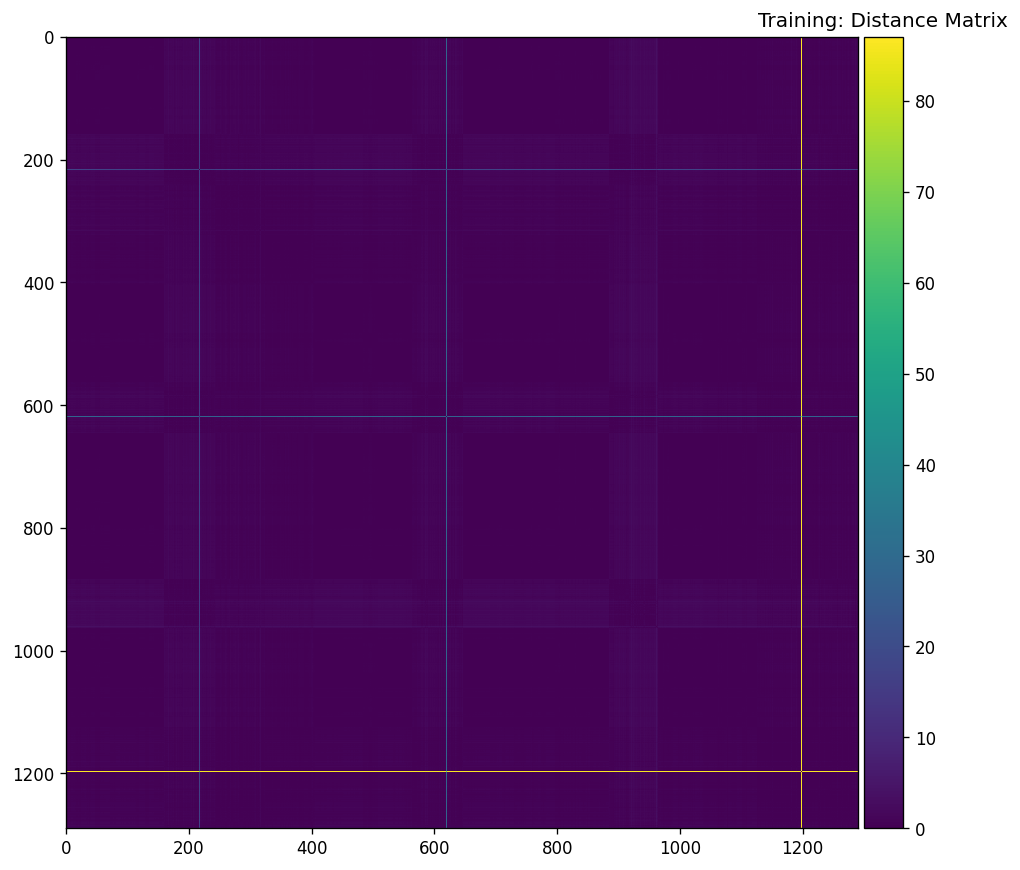

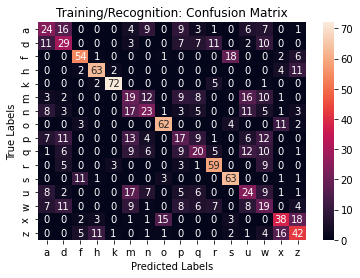

Training recognition rate: 0.4868217054263566


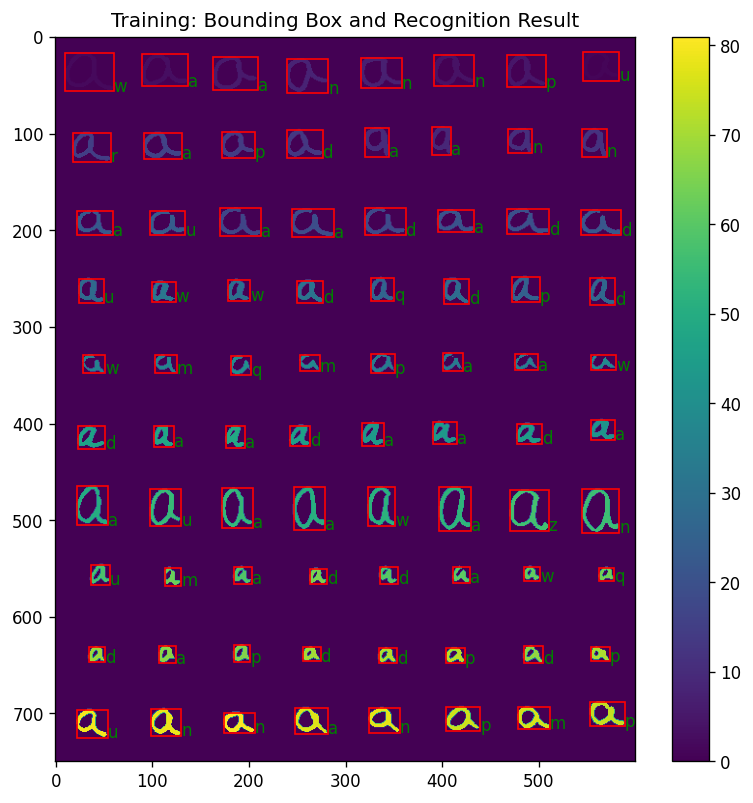

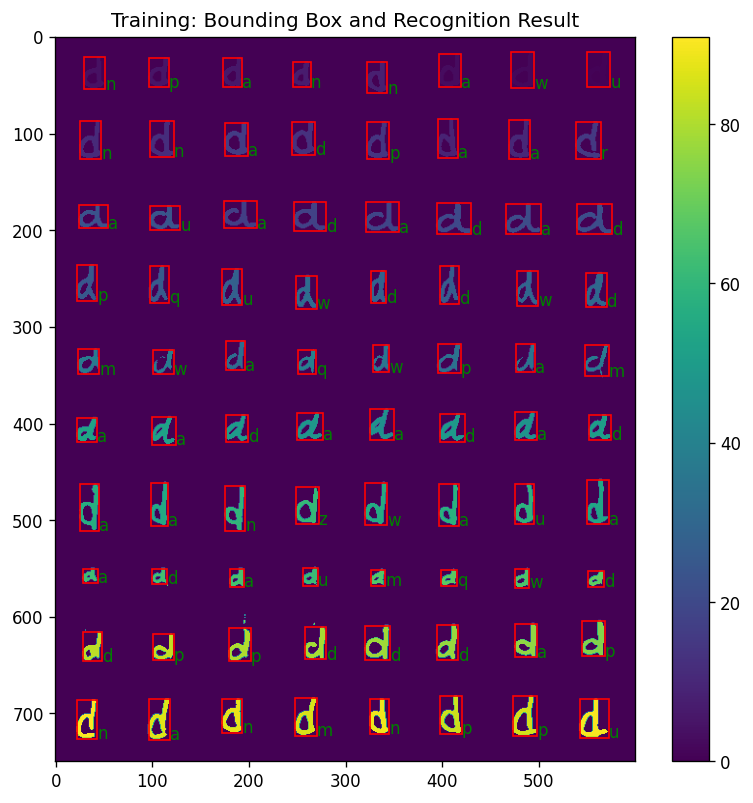

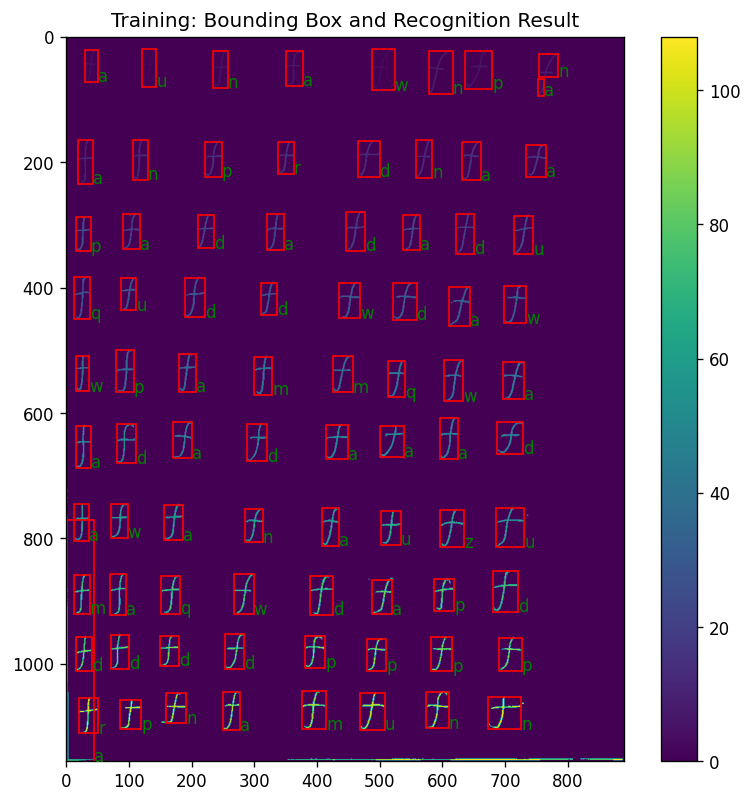

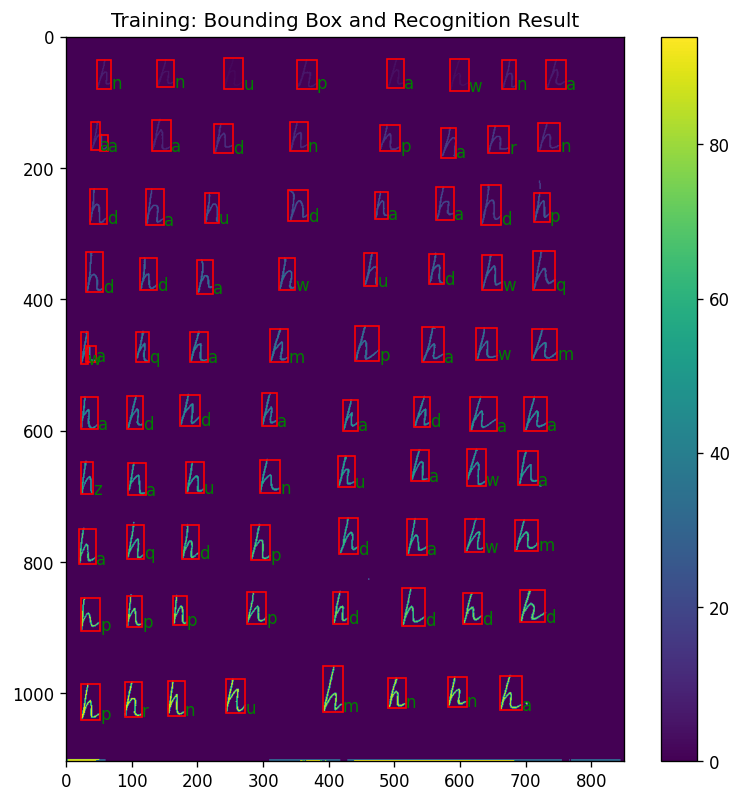

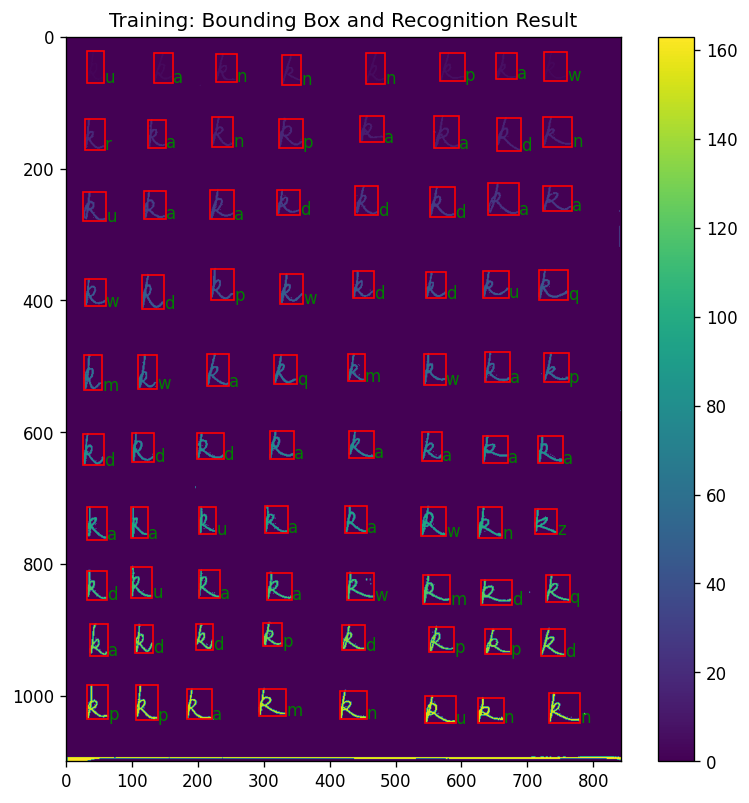

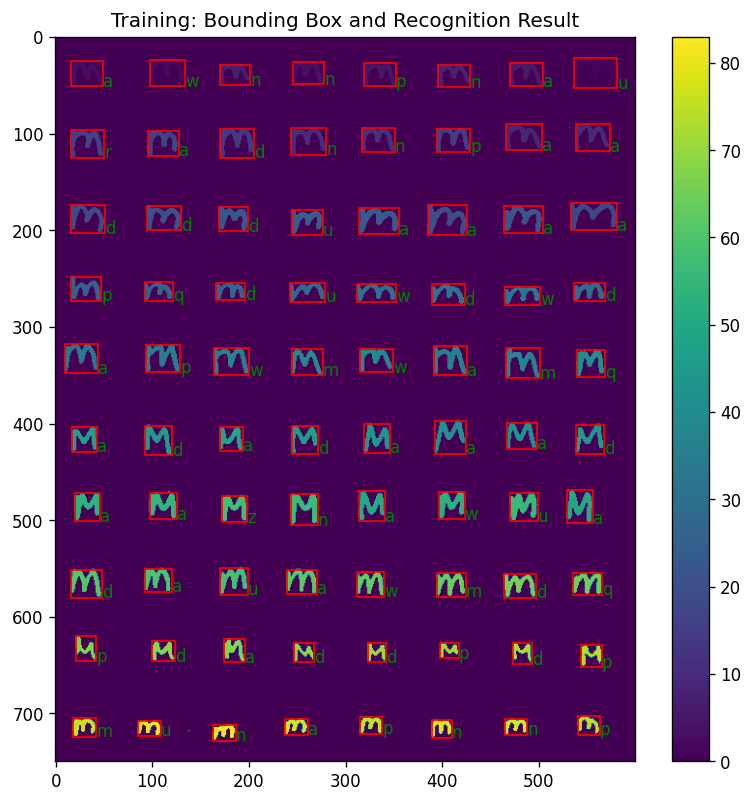

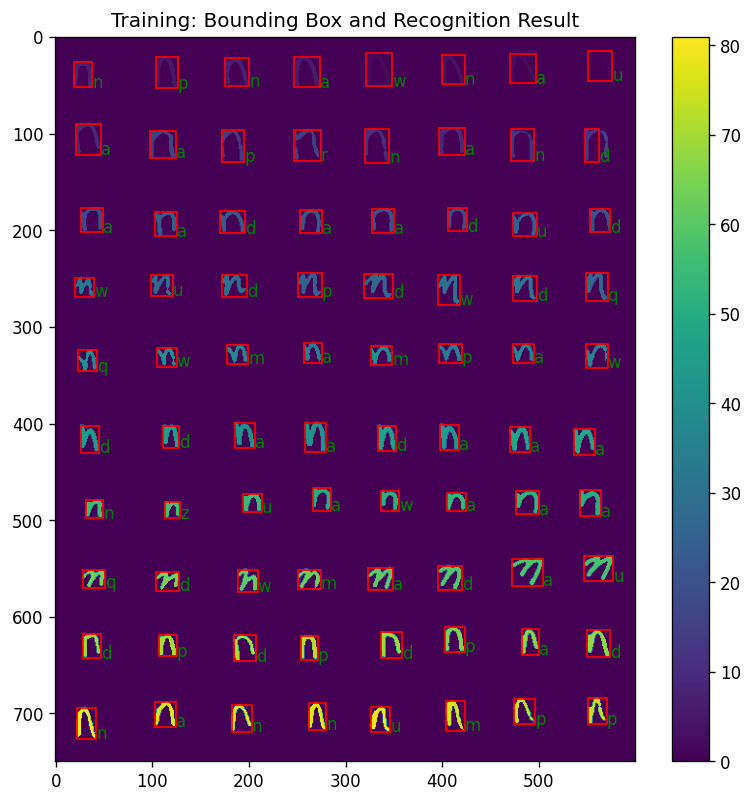

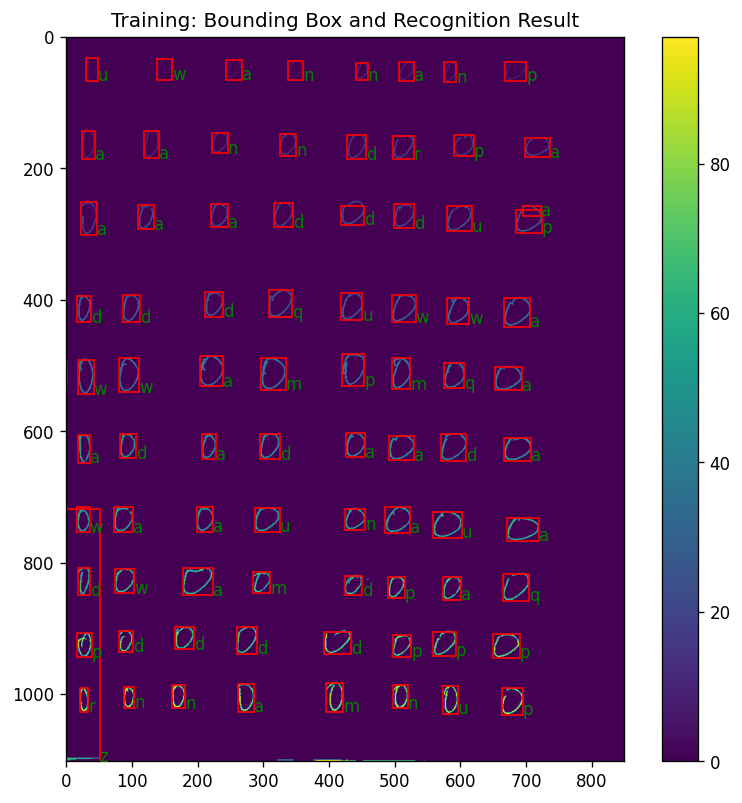

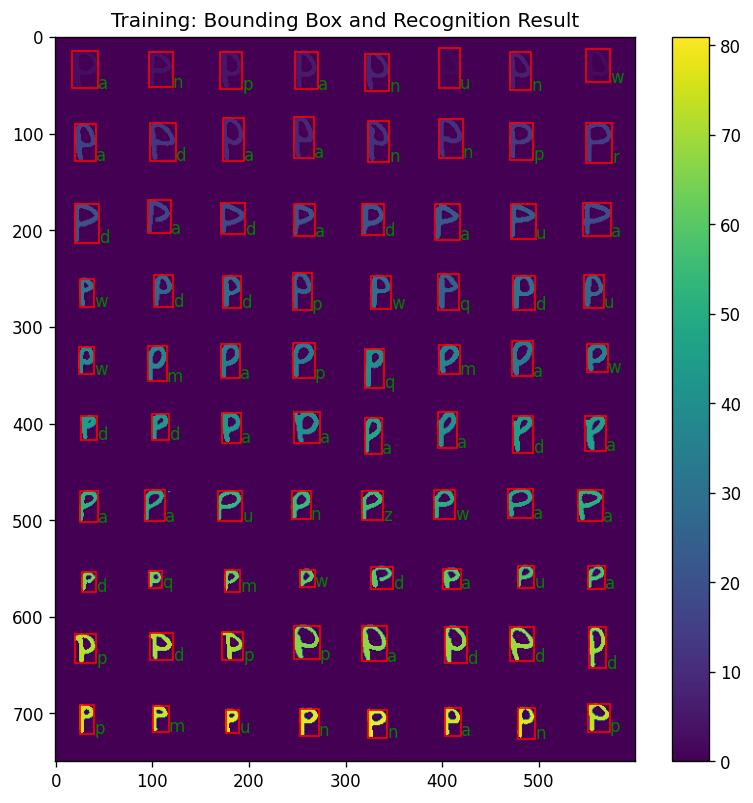

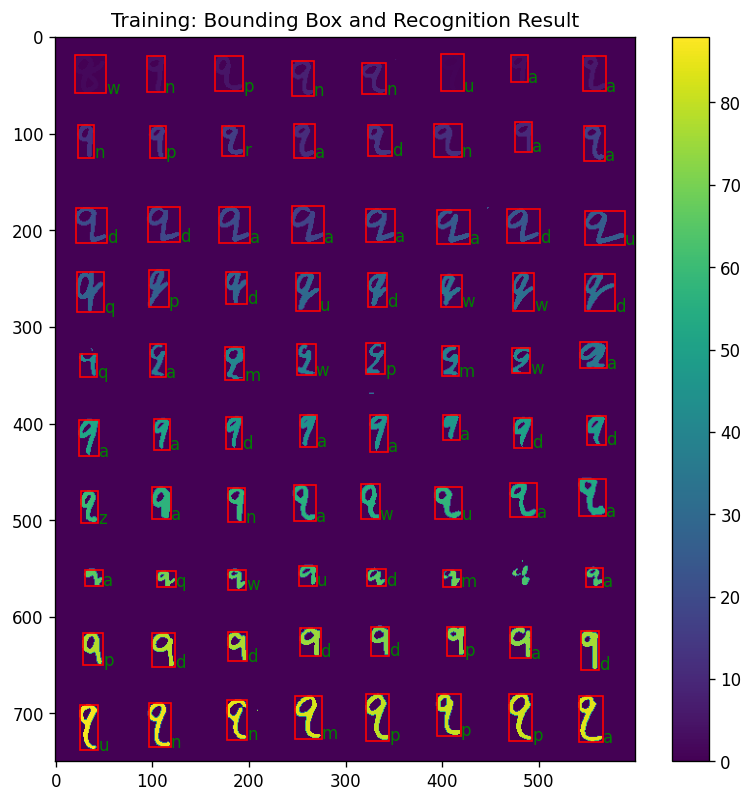

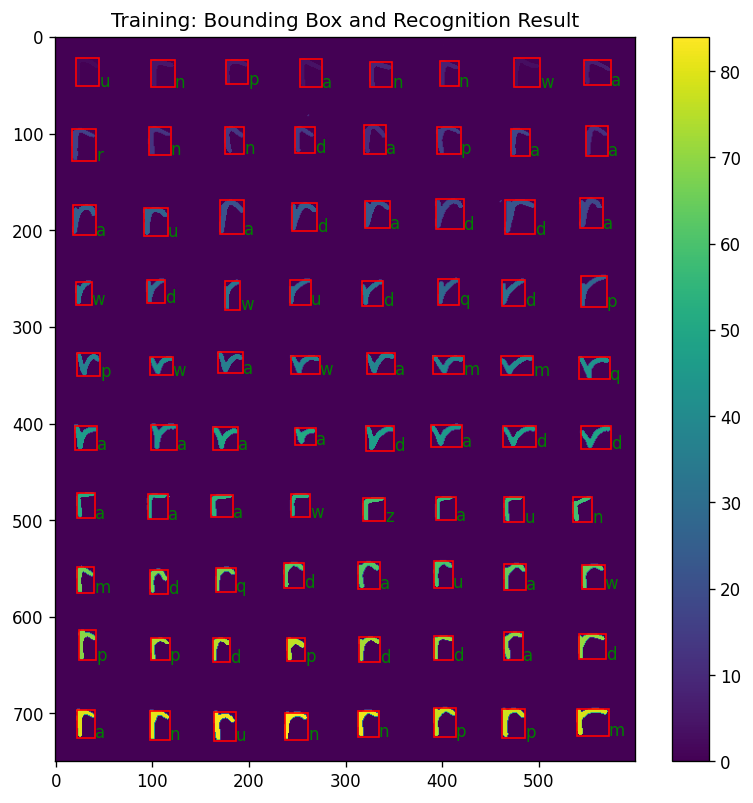

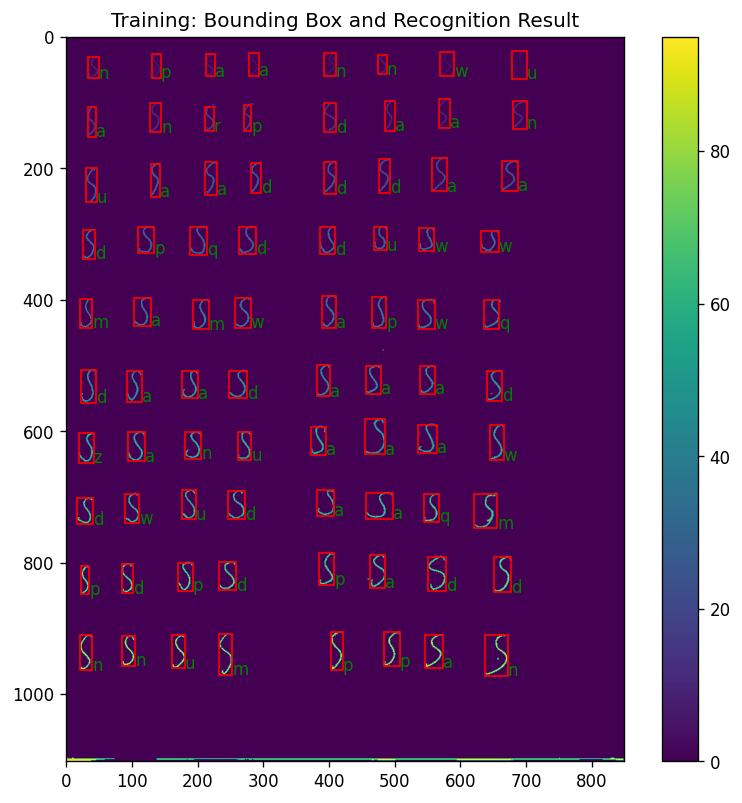

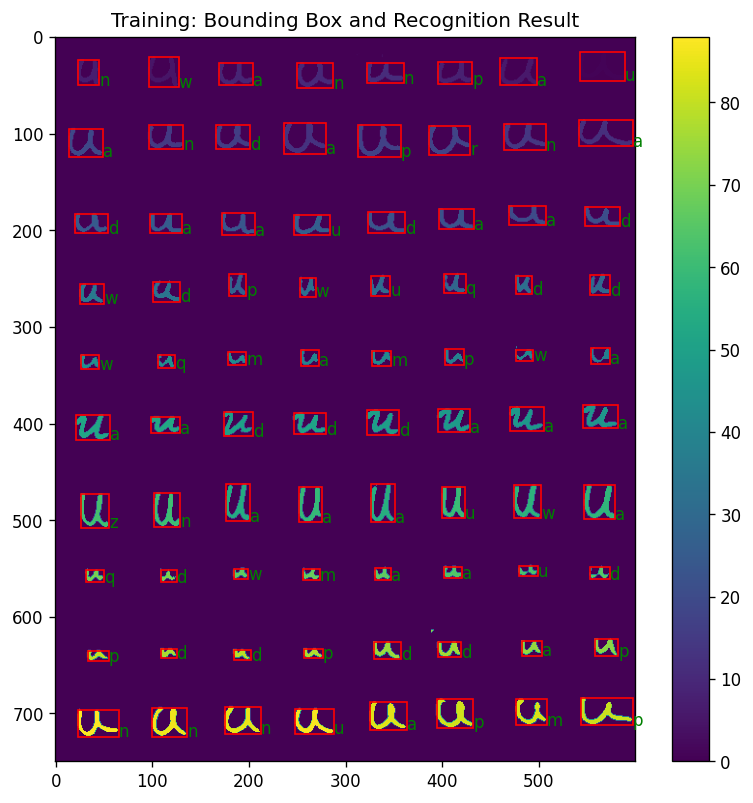

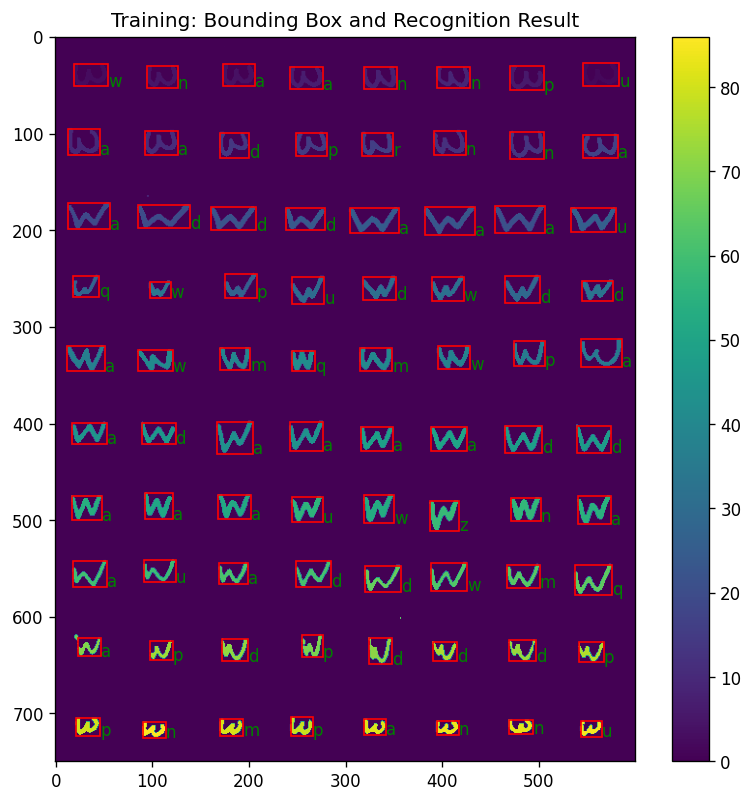

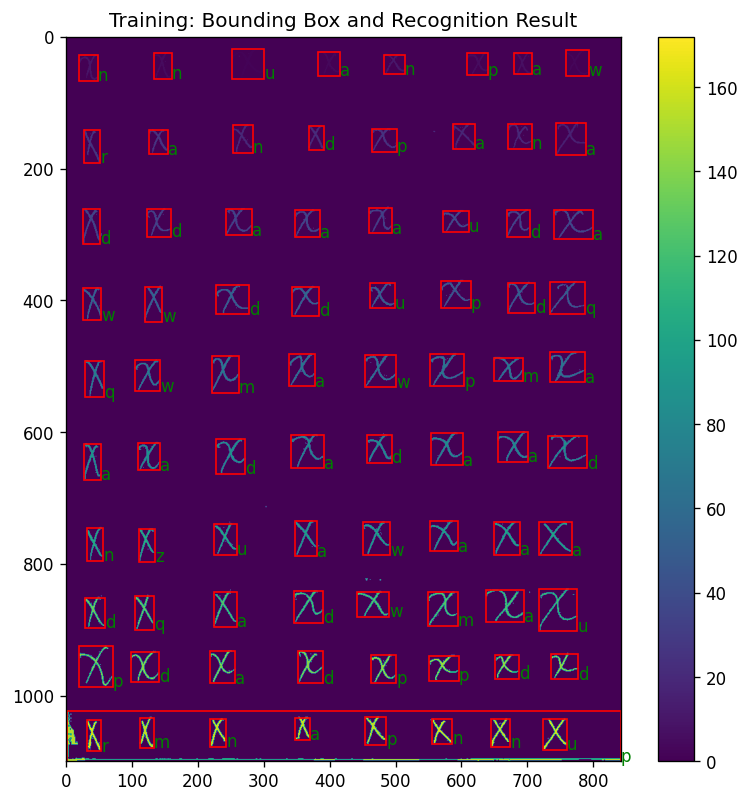

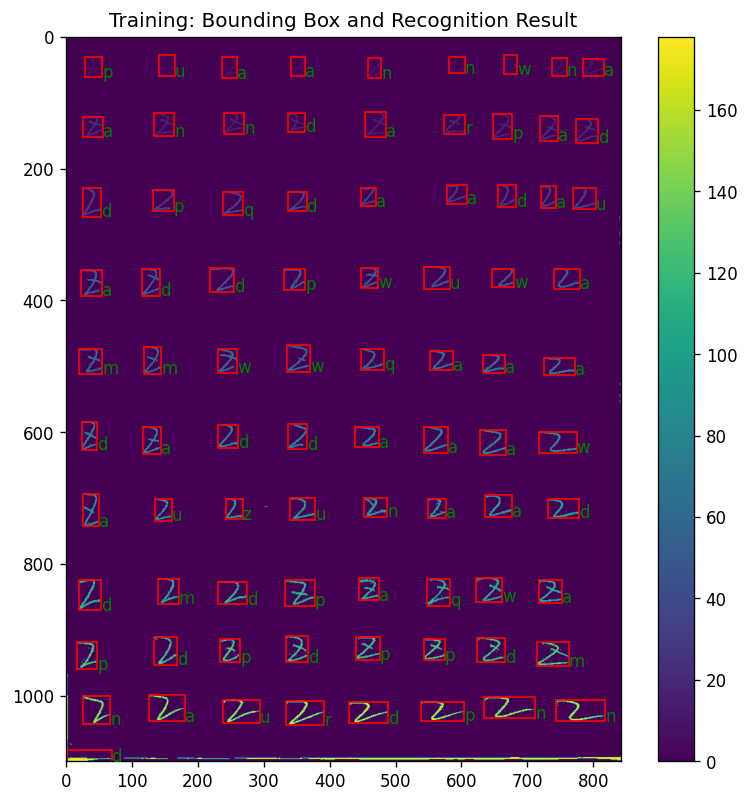

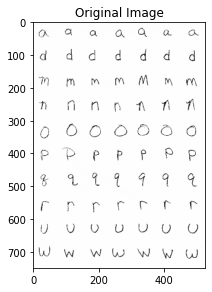

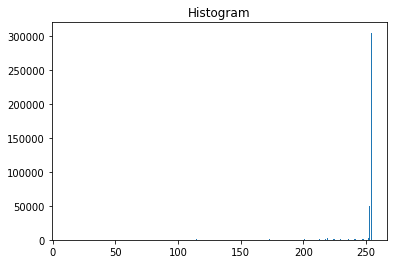

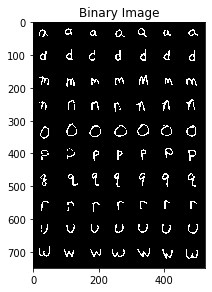

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


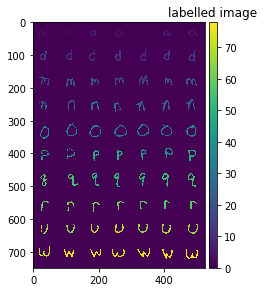

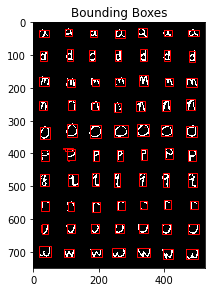

70 70 70 70 ['a' 'a' 'a' 'a' 'a' 'a' 'a' 'd' 'd' 'd' 'd' 'd' 'd' 'd' 'm' 'm' 'm' 'm'
 'm' 'm' 'm' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'p'
 'p' 'p' 'p' 'p' 'p' 'p' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'r' 'r' 'r' 'r' 'r'
 'r' 'r' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'w' 'w' 'w' 'w' 'w' 'w' 'w']
Number of components in testing image: 70
Testing recogition rate: 0.15714285714285714


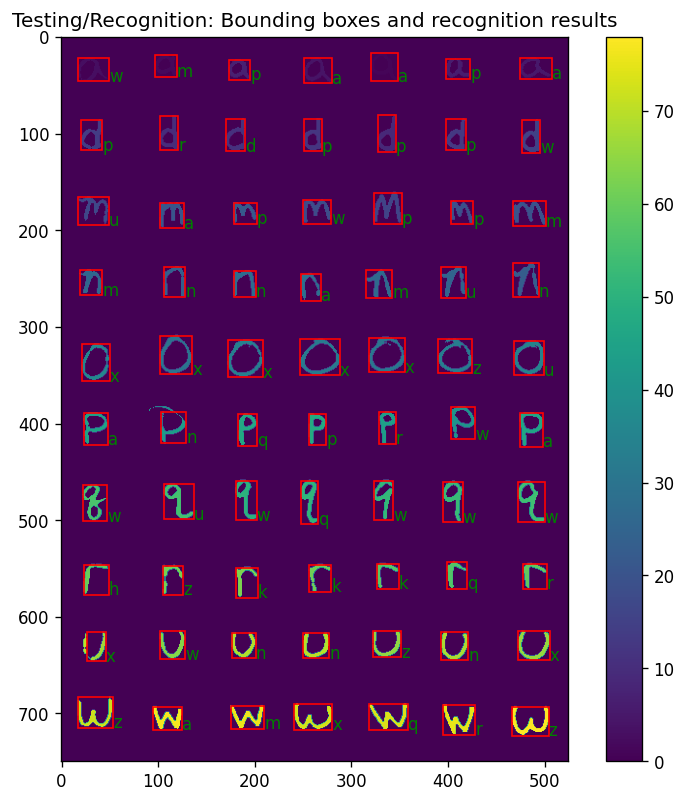

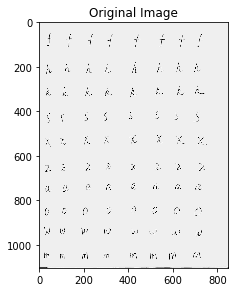

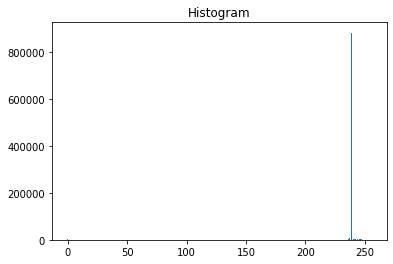

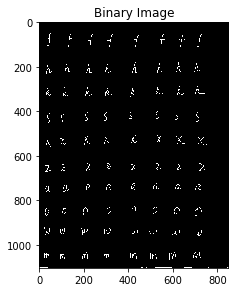

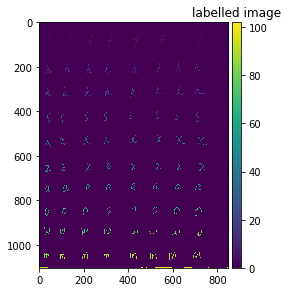

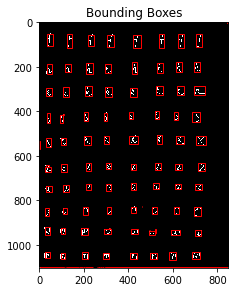

80 80 80 80 ['w' 'm' 'z' 'o' 'x' 'a' 'k' 'f' 'h' 's' 's' 'x' 'w' 'm' 'z' 'k' 'o' 'a'
 'h' 'f' 'w' 'm' 'o' 'x' 's' 'k' 'z' 'a' 'h' 'f' 'm' 's' 'w' 'x' 'h' 'k'
 'z' 'a' 'o' 'f' 'x' 's' 'm' 'k' 'z' 'a' 'o' 'w' 'h' 'f' 'w' 'm' 'o' 'a'
 'z' 's' 'k' 'h' 'x' 'f' 'm' 'w' 'o' 's' 'z' 'a' 'x' 'h' 'k' 'f' 's' 'm'
 'h' 'o' 'k' 'a' 'w' 'f' 'x' 'z']
Number of components in testing image: 80
Testing recogition rate: 0.5125


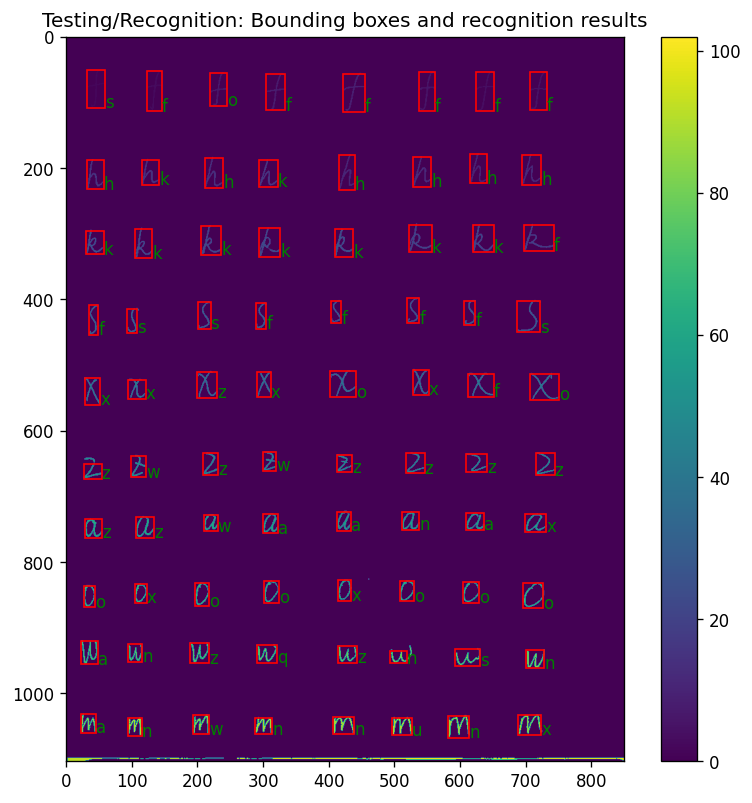

In [ ]:
# Runs training and testing. All bounding box and recognition result plots are shown.
# img_name_list     <- Input: A list of names of the testing image to process, ordered as test1 and test2 
# show_all_plots    <- Input: Show intermediate plots like binarization and thresholding 
# binary_threshold  <- Input: Specifies the threshold for binarizing the image
# min_bbox_height   <- Input: Specifies the minimum height of a bounding box
# min_bbox_width    <- Input: Specifies the minimum width of a bounding box
def pipeline(img_name_list, show_all_plots,
             binary_threshold, min_bbox_height, min_bbox_width):
  
    features_db_list = []
    classes_list     = [] # Contains the character names that correspond with each row in the features_db

    # Build the features database (processing and training) using function `process_training_data`
    region_info = None
    # YOUR CODE HERE
    region_info = process_training_data(features_db_list, classes_list, show_plots=show_all_plots, binary_threshold=binary_threshold)

    assert(len(region_info) == 16) # There are 16 characters. 

    features_db_array = np.asarray(features_db_list)
    classes_array     = np.asarray(classes_list)

    # Run training using function `training_recognition`
    train_recognition_rate = 0

    train_recognition_rate=training_recognition(features_db_list, classes_list, region_info)

    # Run testing/recognition using function `testing_recognition`
    test_recognition_rate_1 = 0
    test_recognition_rate_2 = 0
    # YOUR CODE HERE
    test_recognition_rate_1=testing_recognition(img_name_list[0], features_db_array, classes_array,
         show_plots=show_all_plots, binary_threshold=binary_threshold, bounding_row_threshold=min_bbox_height, bounding_col_threshold=min_bbox_width)
    test_recognition_rate_2=testing_recognition(img_name_list[1], features_db_array, classes_array,
         show_plots=show_all_plots, binary_threshold=binary_threshold, bounding_row_threshold=min_bbox_height, bounding_col_threshold=min_bbox_width)
    
    return train_recognition_rate, test_recognition_rate_1, test_recognition_rate_2

train_recognition_rate, test_recognition_rate_1, test_recognition_rate_2 = pipeline(['test1.bmp', 'test2.bmp'], False, 205, 10, 10)



In [ ]:
### Please do not modify this cell
assert train_recognition_rate > 0.45
assert test_recognition_rate_1 > 0.15
assert test_recognition_rate_2 > 0.45

## Enhancements

After fully completing the training and testing (recognition) parts, you can experiment with different ideas in order to improve your results. Try to fix any problems associated with the previous parts of your code before attempting to enhance it. If an enhancement is a successful one, it should increase recognition rate of the test images. An enhancement that increases one recognition rate, but decreases the other is not a good one. 

Improving your results using different enhancements will contribute up to 20% of the assignment grade.

An enhancement can be completely experimental or it can be a remedy for a shortcoming that you observed in the current setting. If you are specifically testing an enhancement that should fix a problem in the current setting, try to observe/measure the resulting improvement on the problem you were targeting, instead of only measuring the recognition rate improvement. It may be a good idea to test improvements independently first, then combined together. You would not want to test ten different enhancements and be not sure which one made an improvement and which made it worse. 

Make sure you document every thing in your report, even the unsuccessful ideas and trials. 

In your report we would like to see:

* What you observed: A problem or an unsatisfactory point.
* What you deducted from it: Why this is happening, what is the main reason of this.
* What solution you came up with: A candidate solution designed to solve this particular problem.
* this solution worked: Improvements in recognition rate from this specific enhancement and how the problem is solved, maybe with sample images or measurements. If failed to fix the problem or it introduced another problem, why do you think it failed.

### Enhancement Ideas

* Automate the threshold selection process: instead of a fixed hard-coded threshold, find methods that analyze the images and find the best threshold.
* Use binary morphology: Using binary morphology might be useful if you have fragmented characters that you cannot get rid of solely by improving the thresholding. There could be many other uses for binary morphology. 
* Investigate different shape and region descriptors to extract invariant features to be used in the recognition: More invariant moments, shape profiles, contour descriptors, etc. Make sure you perform a meaningful normalization on each new feature you included. Sometimes you will not need to normalize a feature using mean and variance, but maybe using its known bounds.
* Use a better classifier: Instead of the nearest neighbor (closest distance) from the features’ database for recognition, you can find the k-nearest neighbors (k is small number 3, 5, 7) and do a majority vote. If you have a Machine Learning background and you think another classifier will perform better, go ahead and try it. Document everything you do and make sure you do not concentrate only on the classification problem, since this is a Computer Vision assignment. 

You don’t have to investigate all the above possibilities. These are just some ideas. You need to come up with a way to enhance the recognition rate. You should use the training data for validating your proposed approach and the test image for testing only (no training done on it). Keep in mind that your final code will be evaluated with a similar image, which will not be given to you. Your grade in this part will be based on how much improvement you can do over the base line established in previous parts. 

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


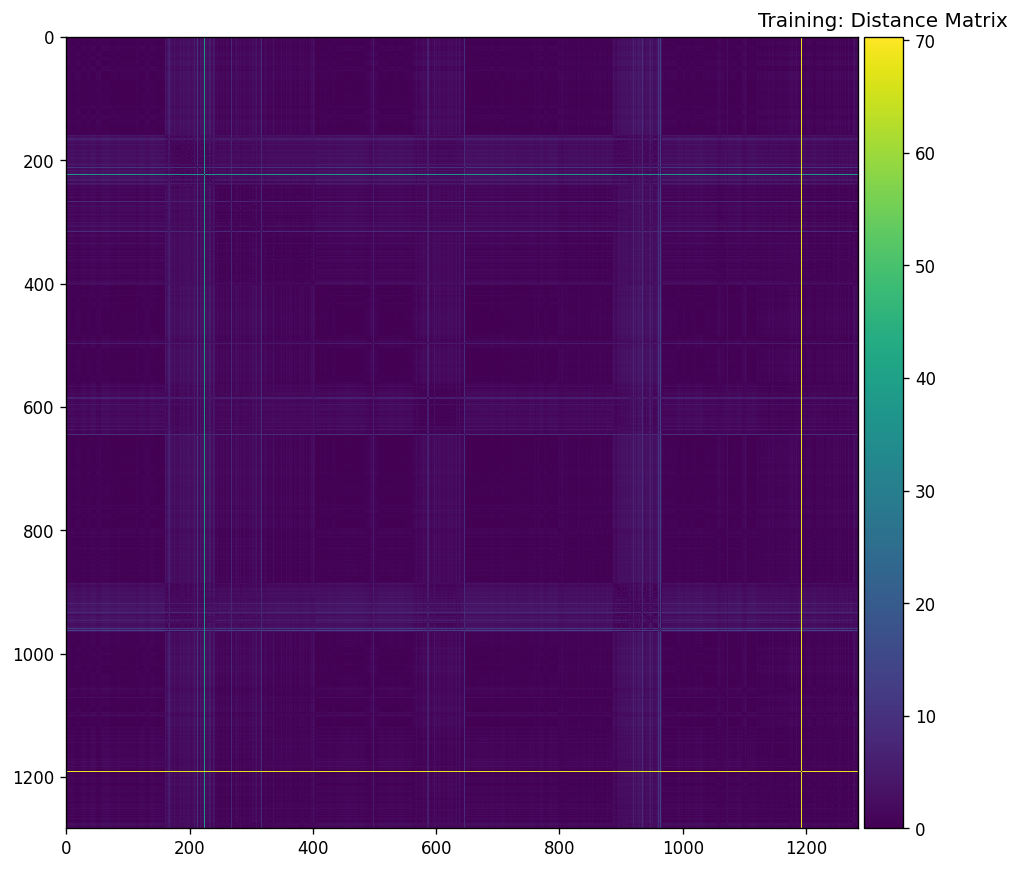

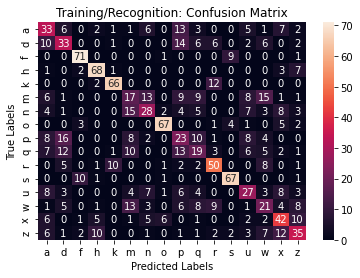

Training recognition rate: 0.5194704049844237


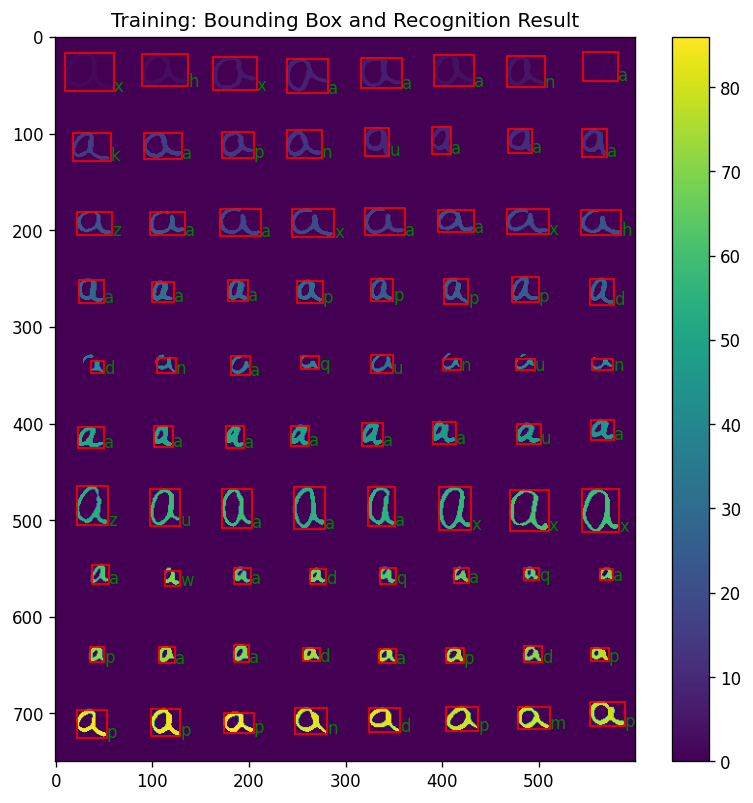

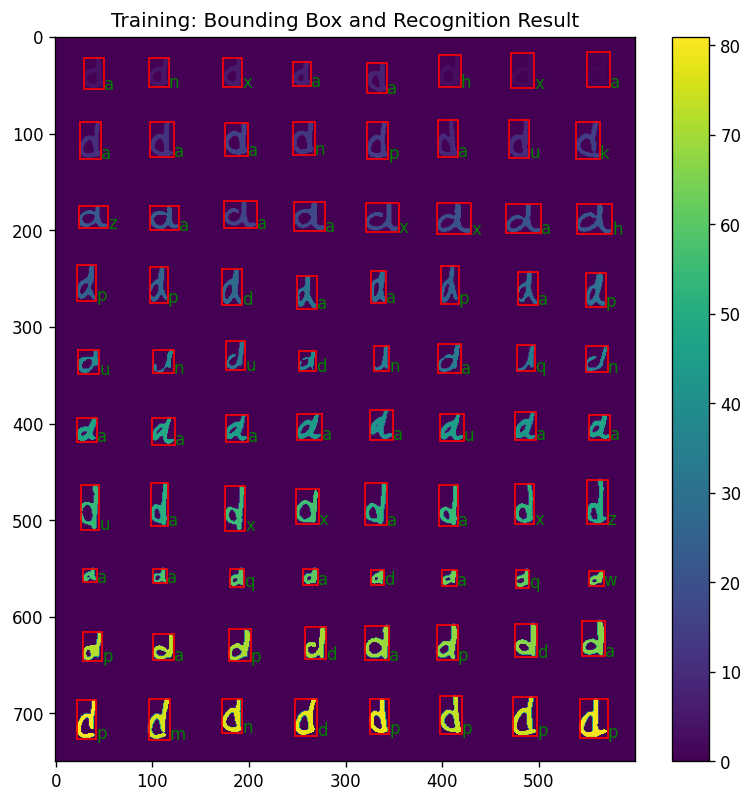

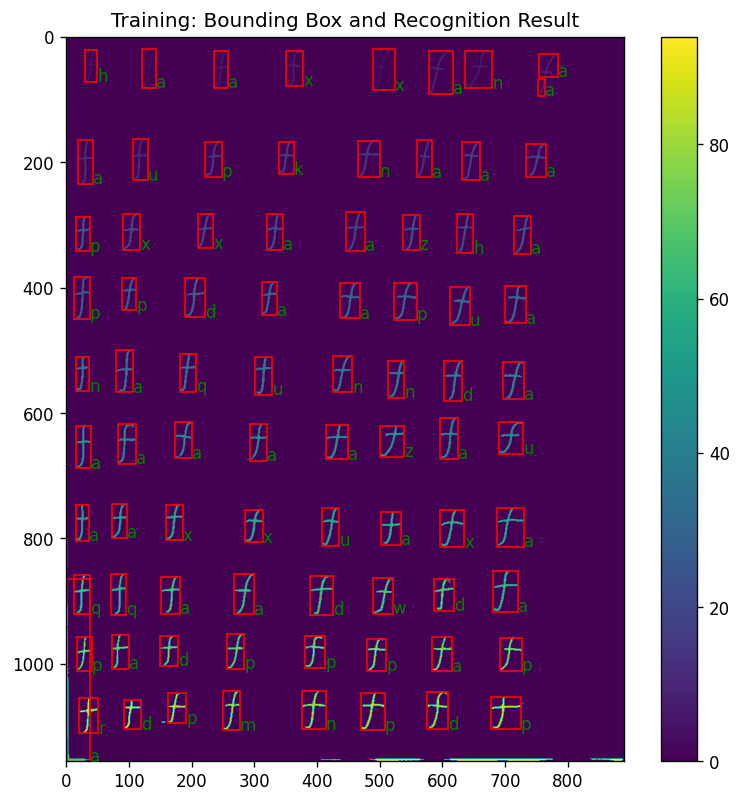

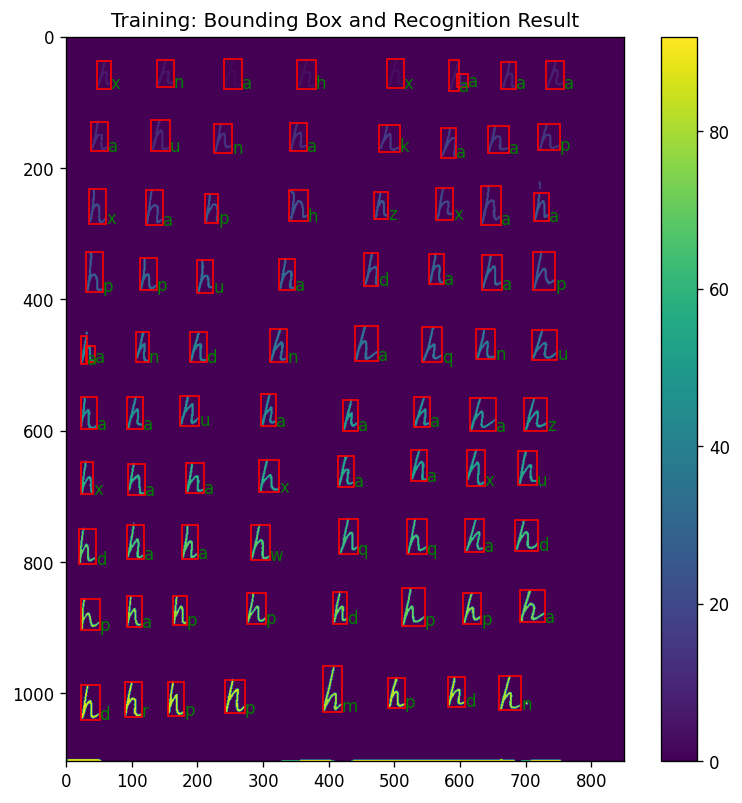

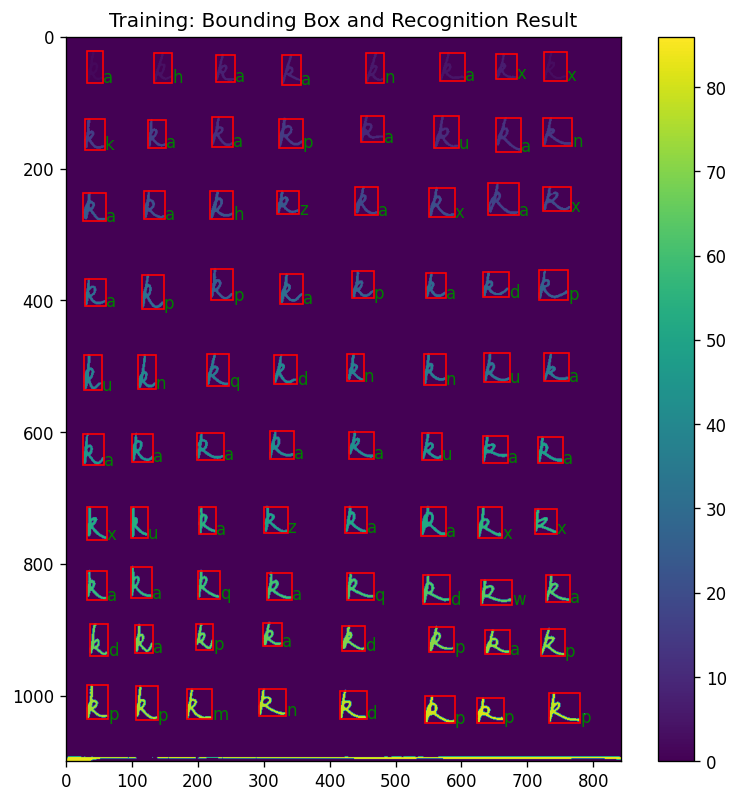

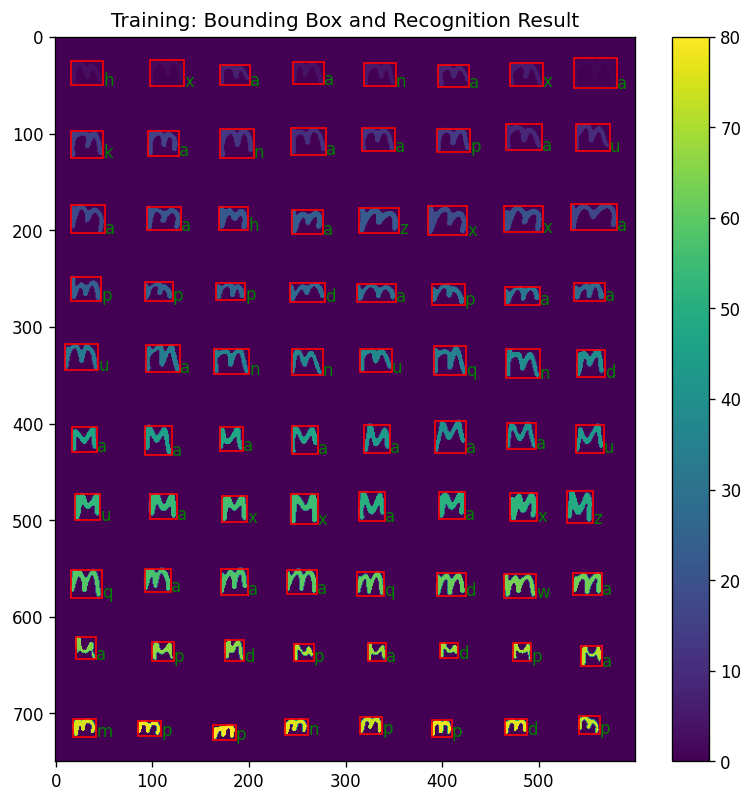

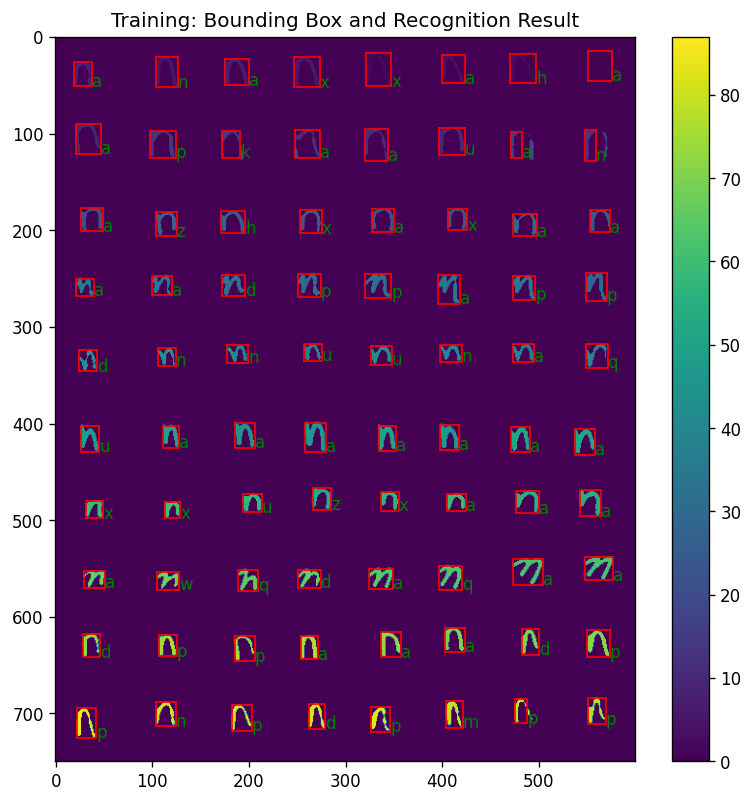

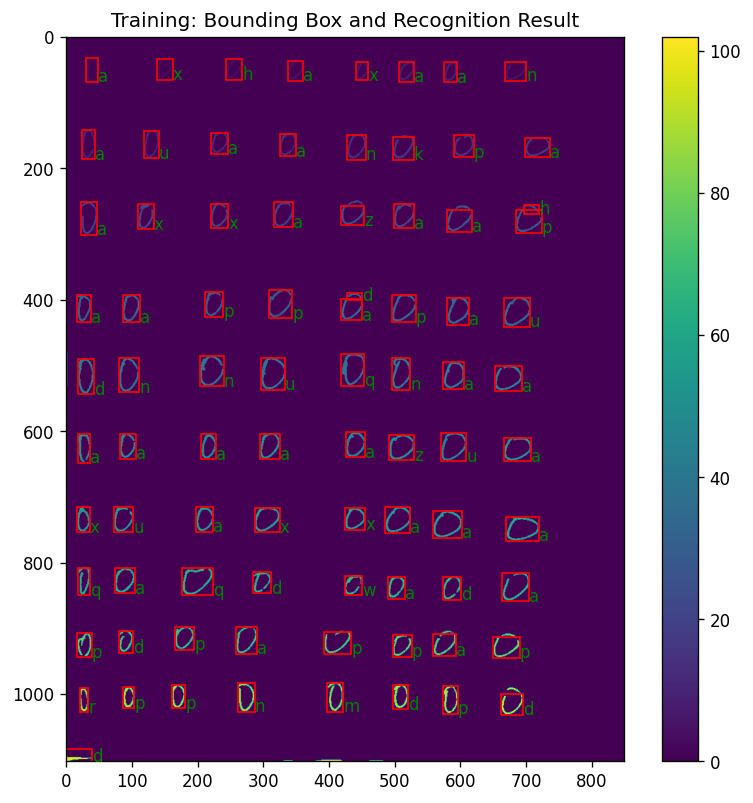

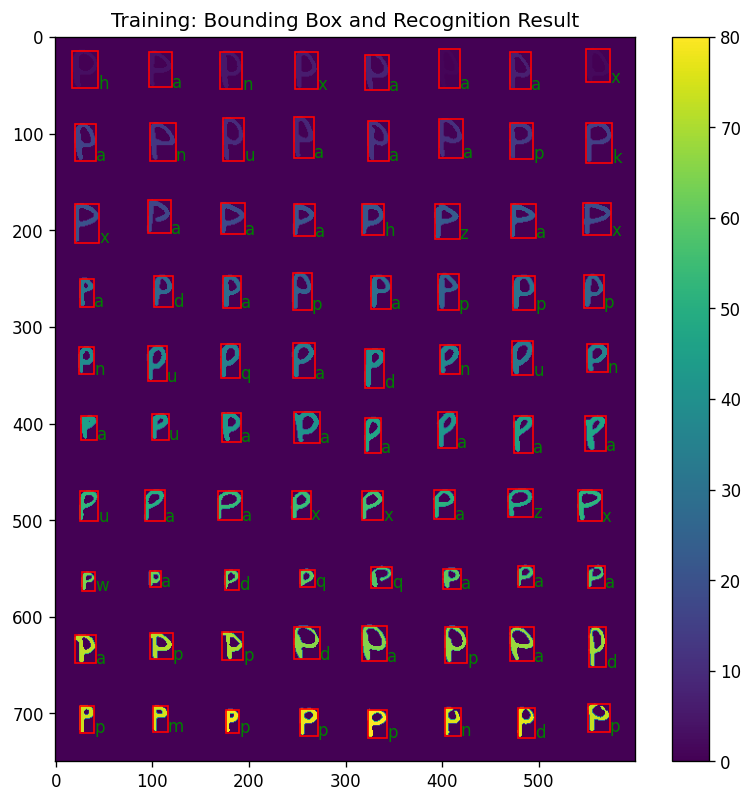

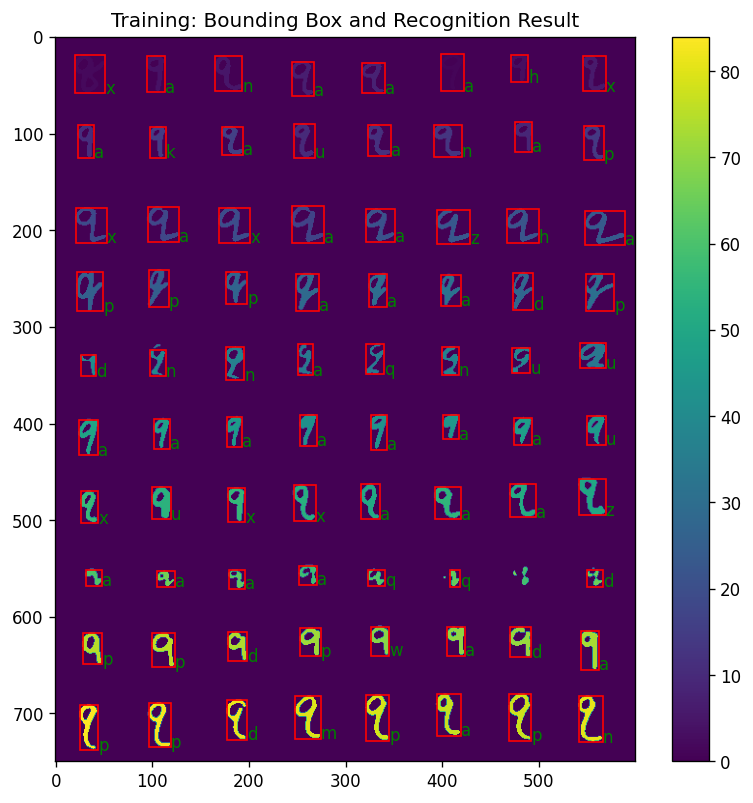

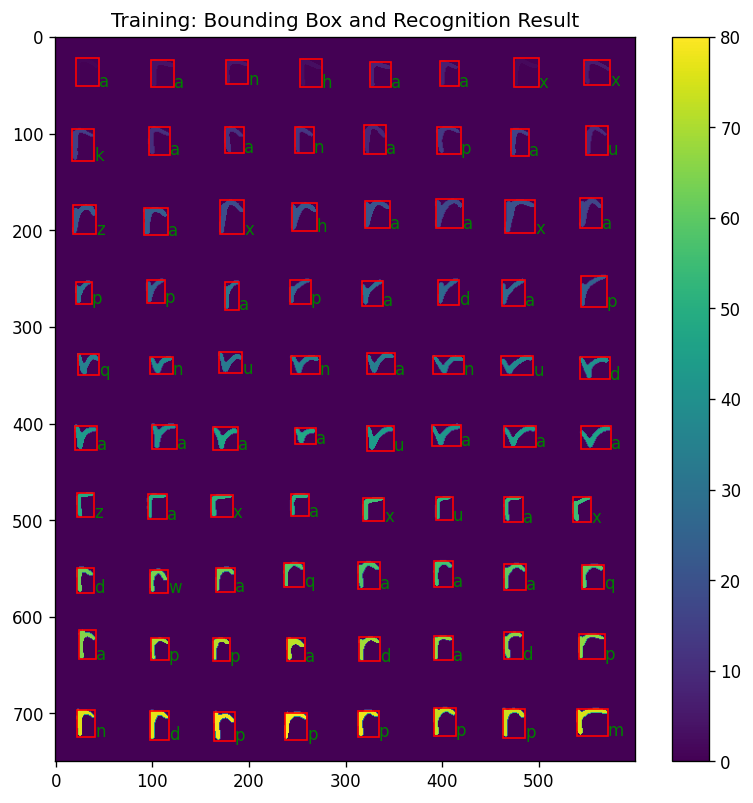

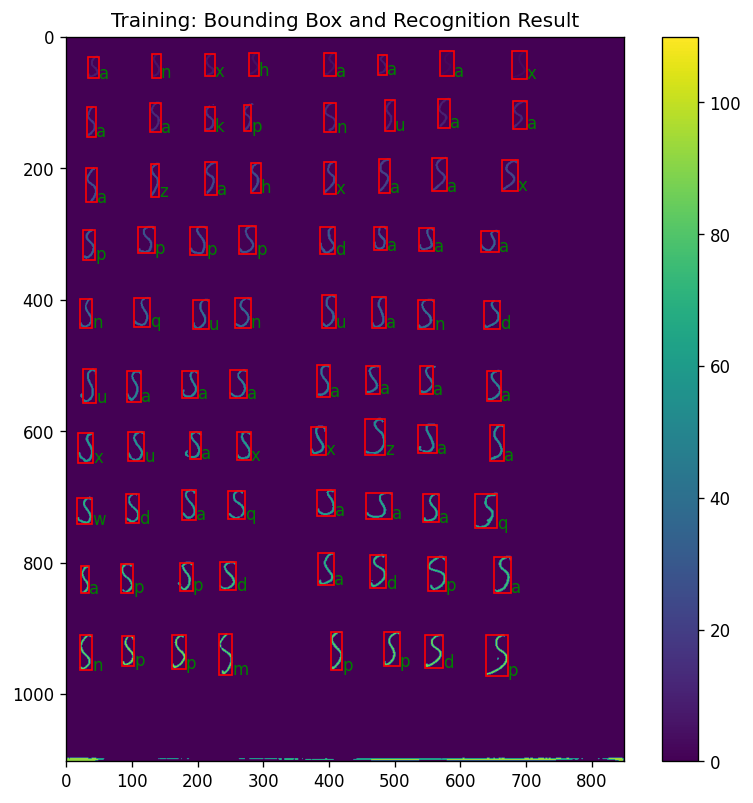

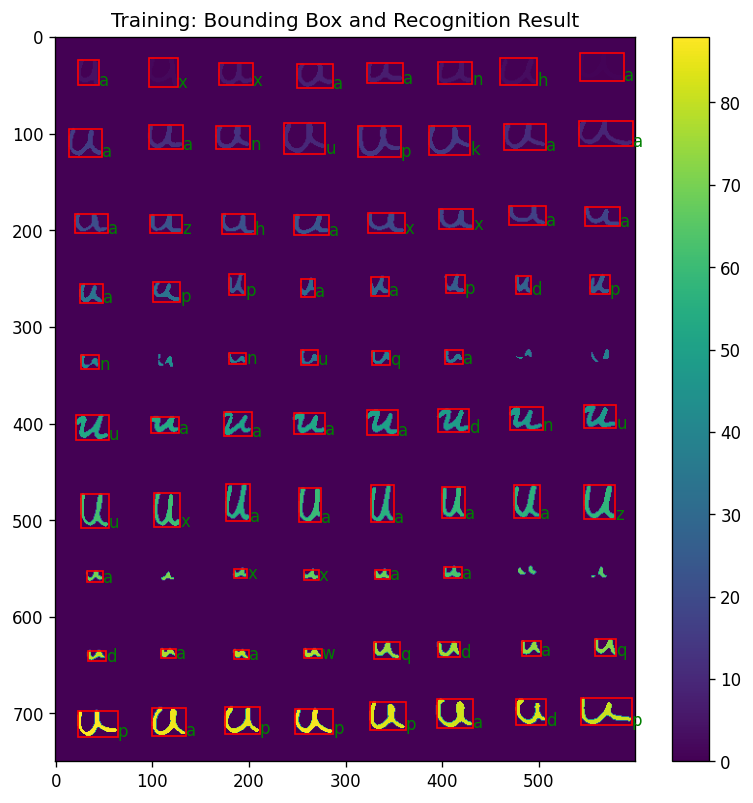

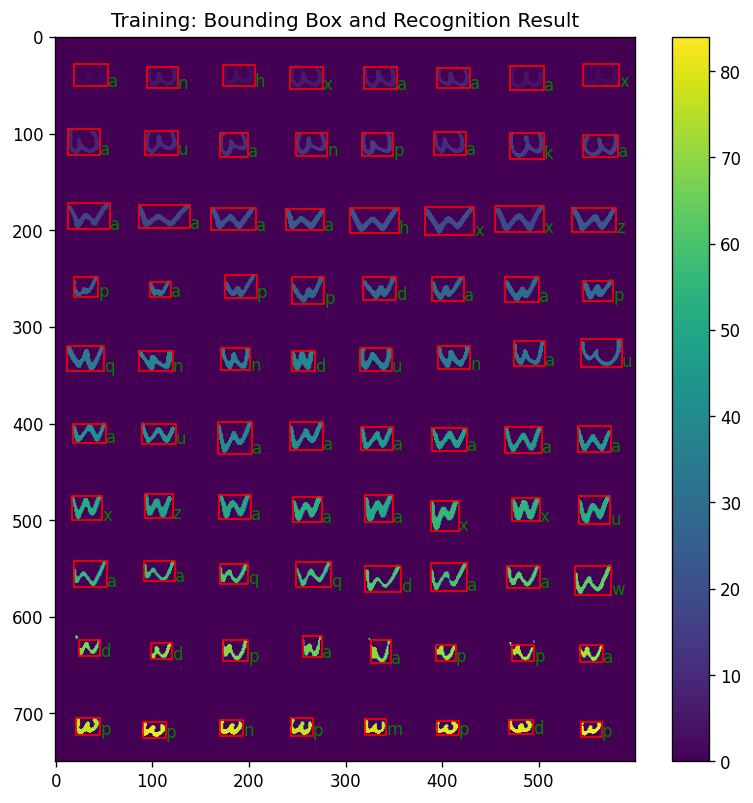

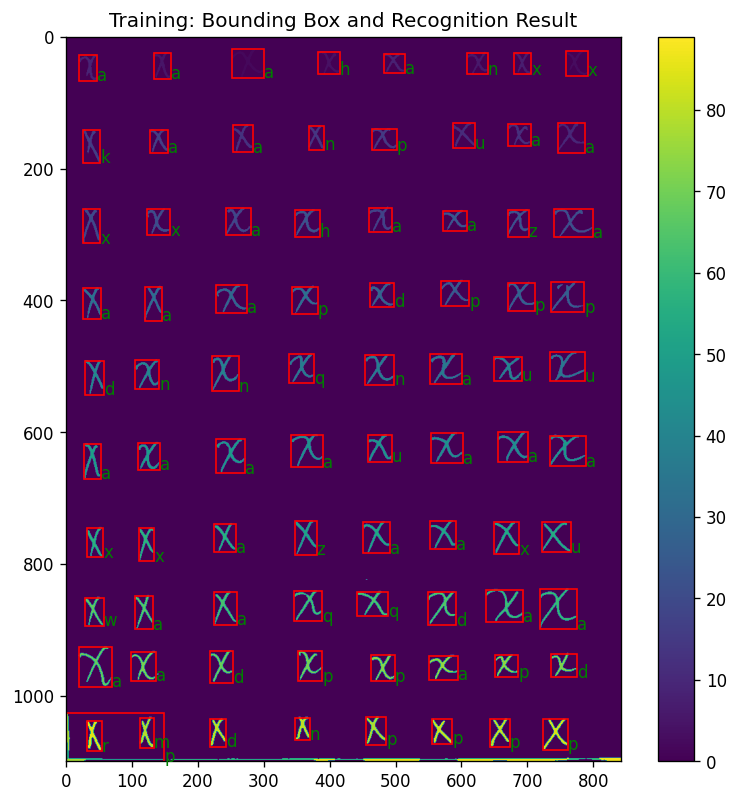

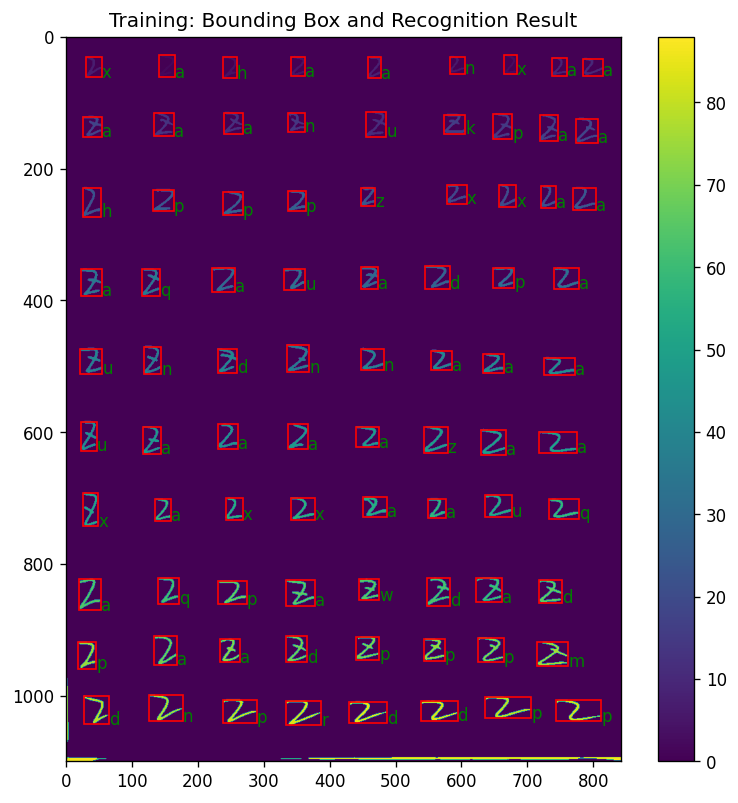

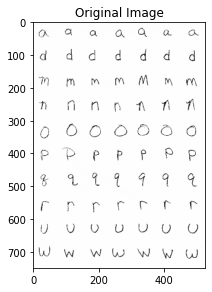

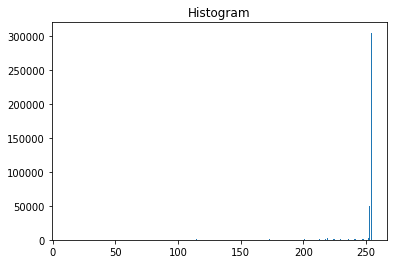

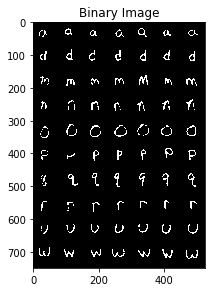

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


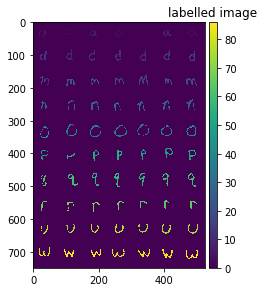

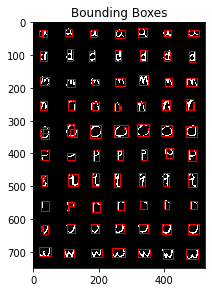

70 68 70 68 ['a' 'a' 'a' 'a' 'a' 'a' 'a' 'd' 'd' 'd' 'd' 'd' 'd' 'd' 'm' 'm' 'm' 'm'
 'm' 'm' 'm' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'p'
 'p' 'p' 'p' 'p' 'p' 'p' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'r' 'r' 'r' 'r' 'r'
 'r' 'r' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'w' 'w' 'w' 'w' 'w' 'w' 'w']
Number of components in testing image: 68
Testing recogition rate: 0.2714285714285714


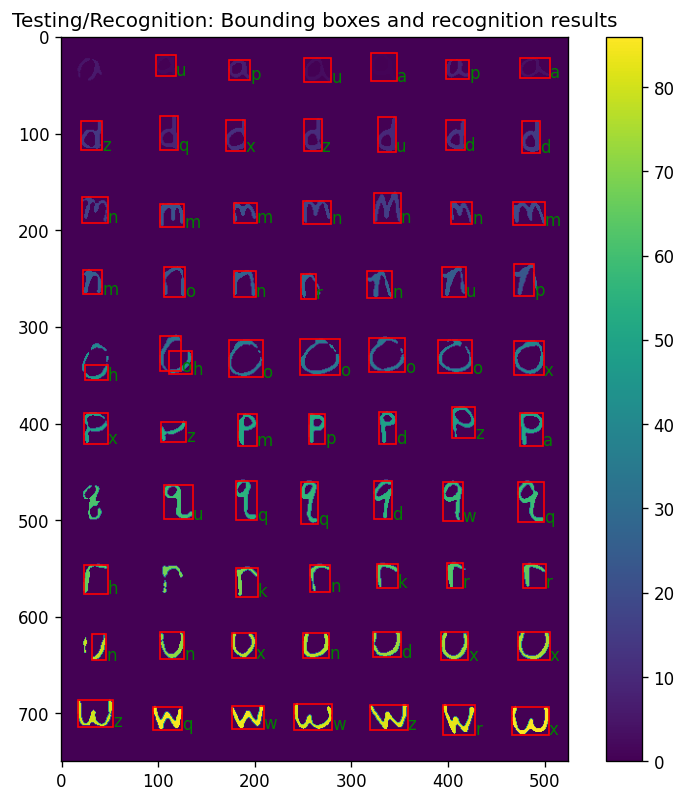

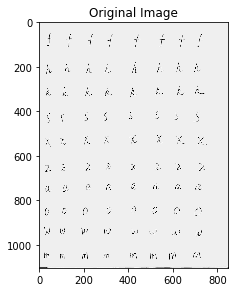

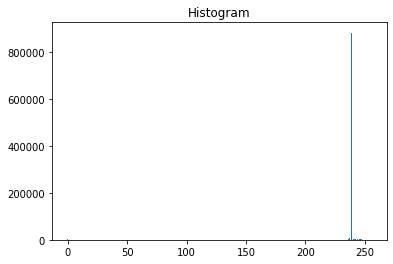

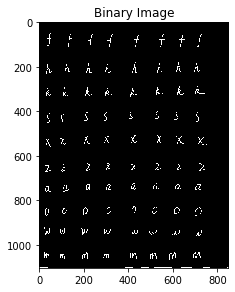

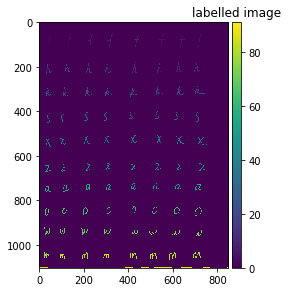

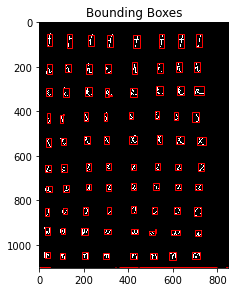

80 79 80 79 ['w' 'm' 'z' 'o' 'x' 'a' 'k' 'f' 'h' 's' 's' 'x' 'w' 'm' 'z' 'k' 'o' 'a'
 'h' 'f' 'w' 'm' 'o' 'x' 's' 'k' 'z' 'a' 'h' 'f' 'm' 's' 'w' 'x' 'h' 'k'
 'z' 'a' 'o' 'f' 'x' 's' 'm' 'k' 'z' 'a' 'o' 'w' 'h' 'f' 'w' 'm' 'o' 'a'
 'z' 's' 'k' 'h' 'x' 'f' 'm' 'w' 'o' 's' 'z' 'a' 'x' 'h' 'k' 'f' 's' 'm'
 'h' 'o' 'k' 'a' 'w' 'f' 'x' 'z']
Number of components in testing image: 79
Testing recogition rate: 0.5375


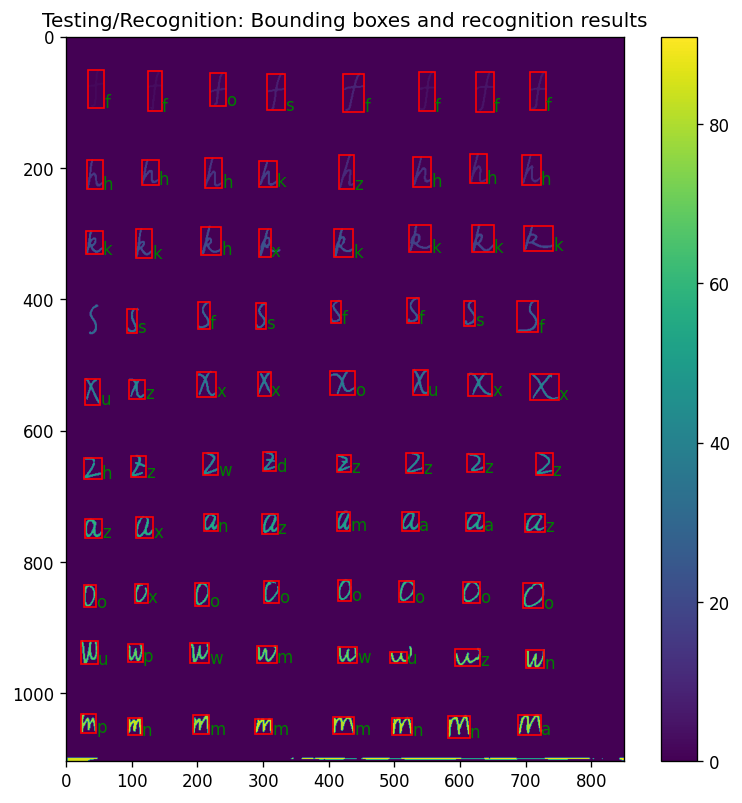

End of Guassian
Combined Model
Training confusion matrix:
[[80  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 82  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 83  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 79  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 79  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 81  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 84]]
Training recognition rate: 1.0


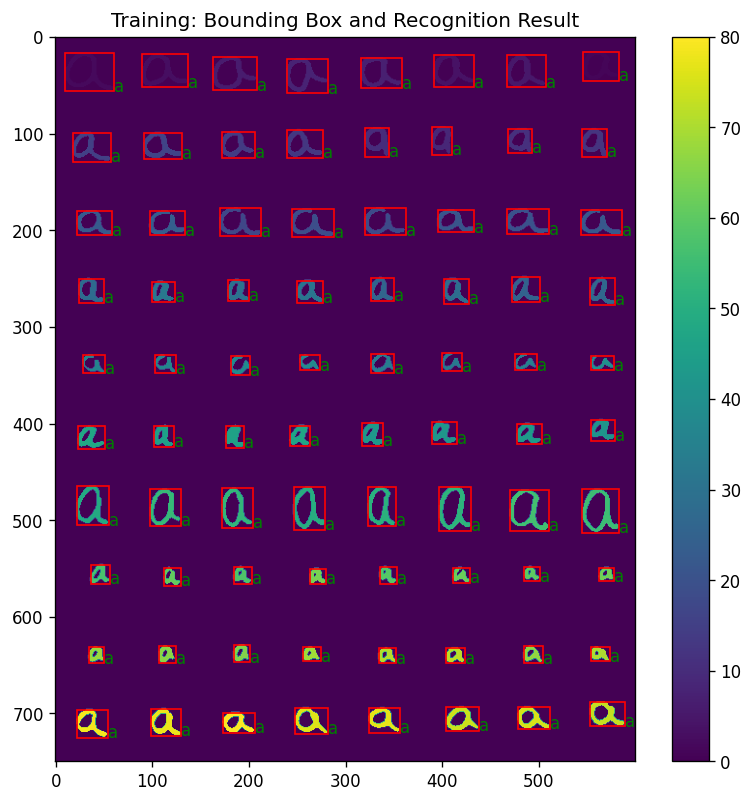

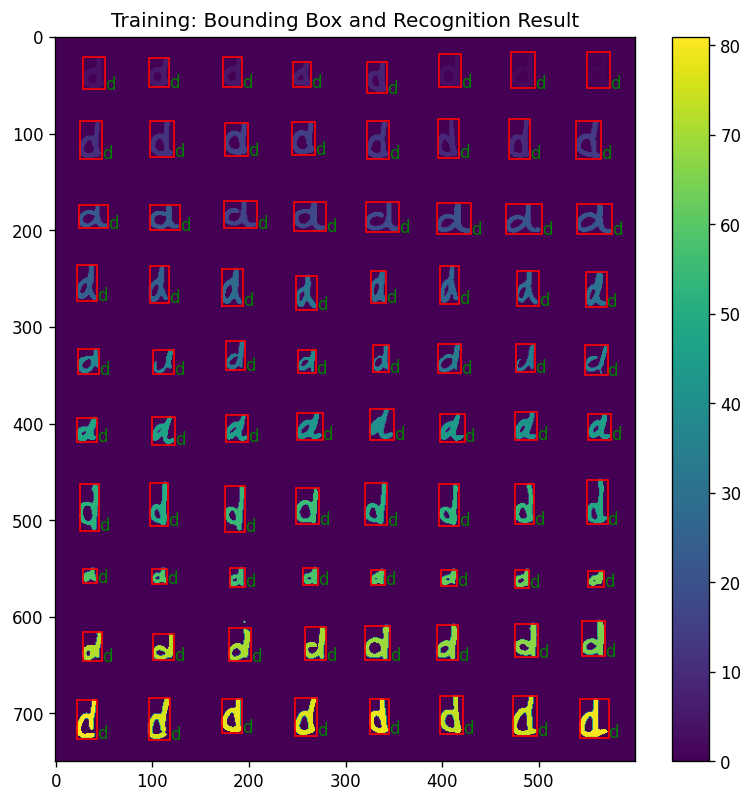

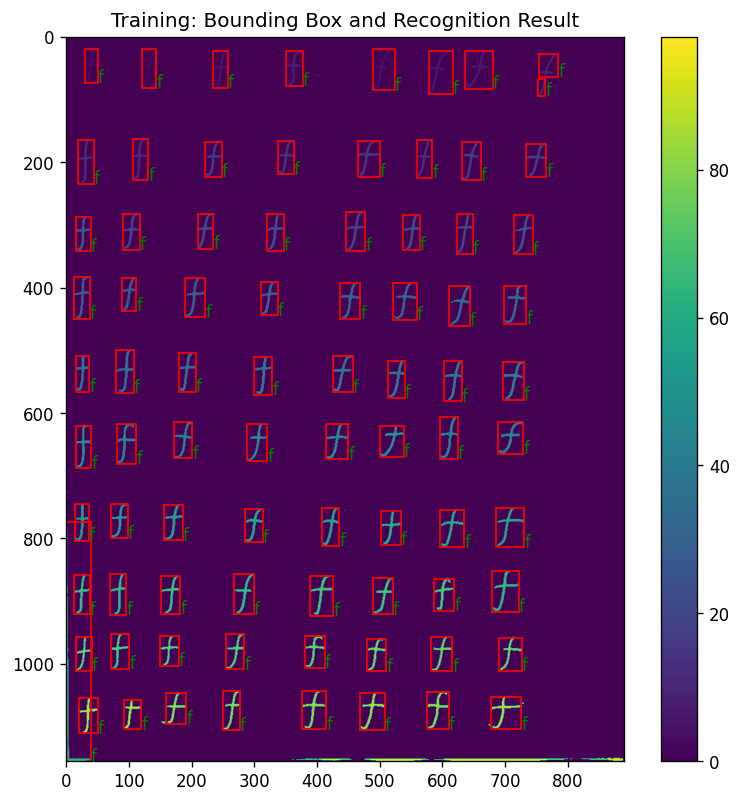

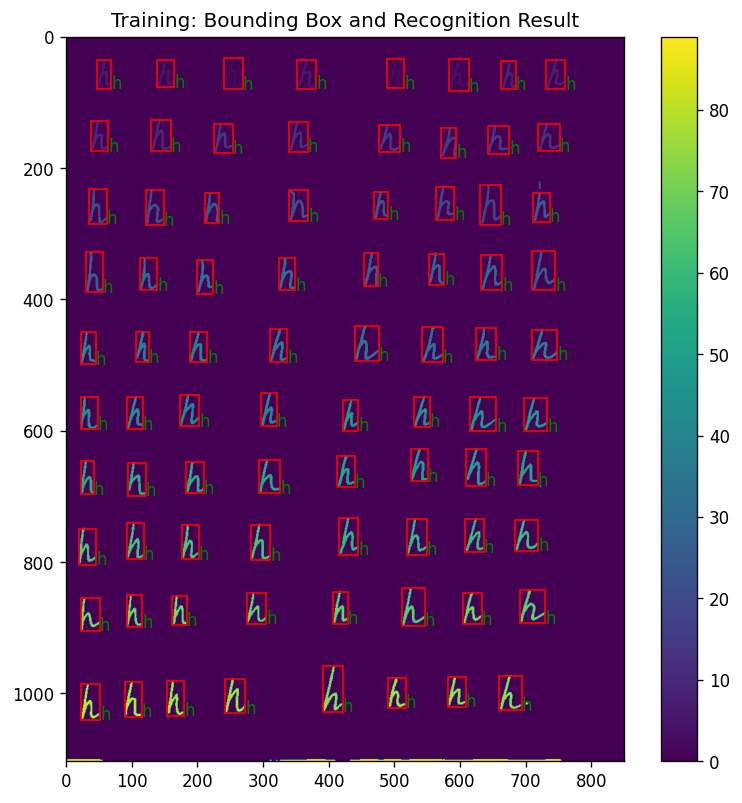

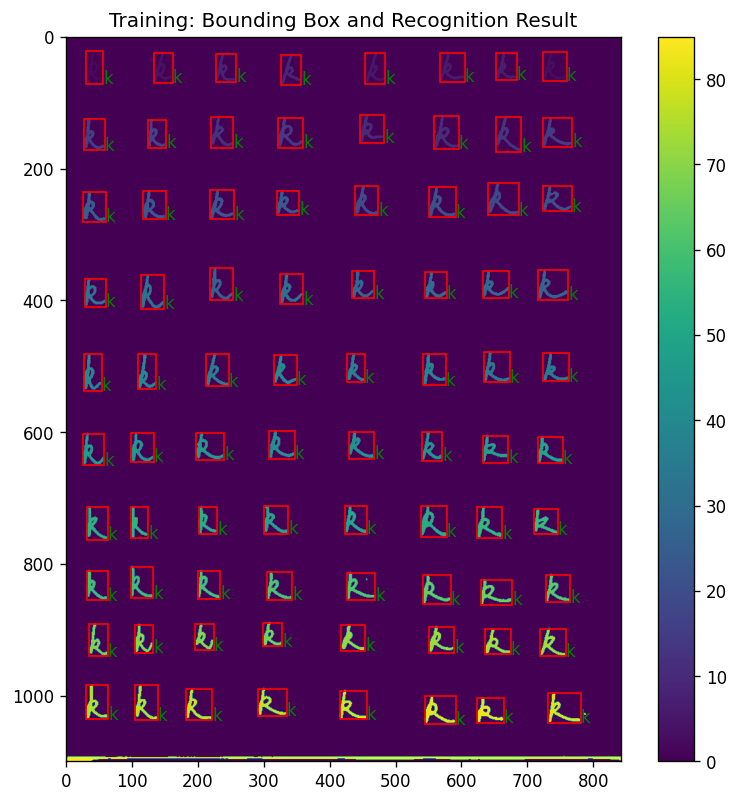

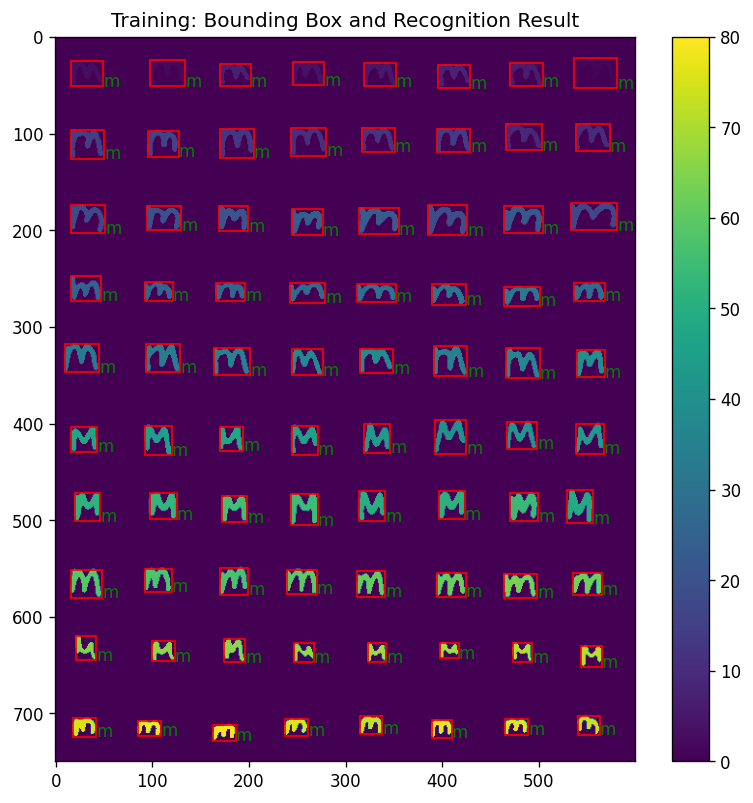

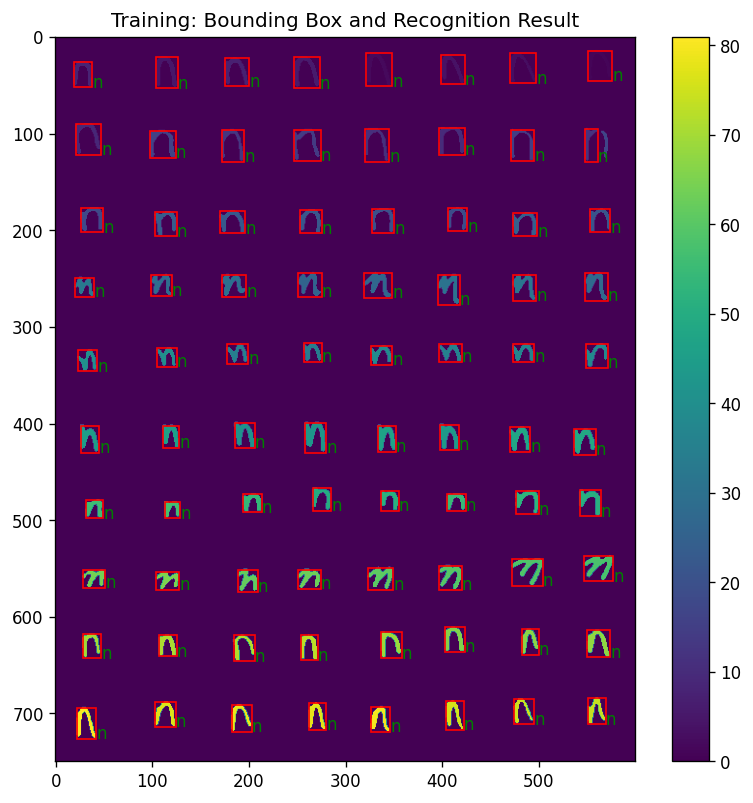

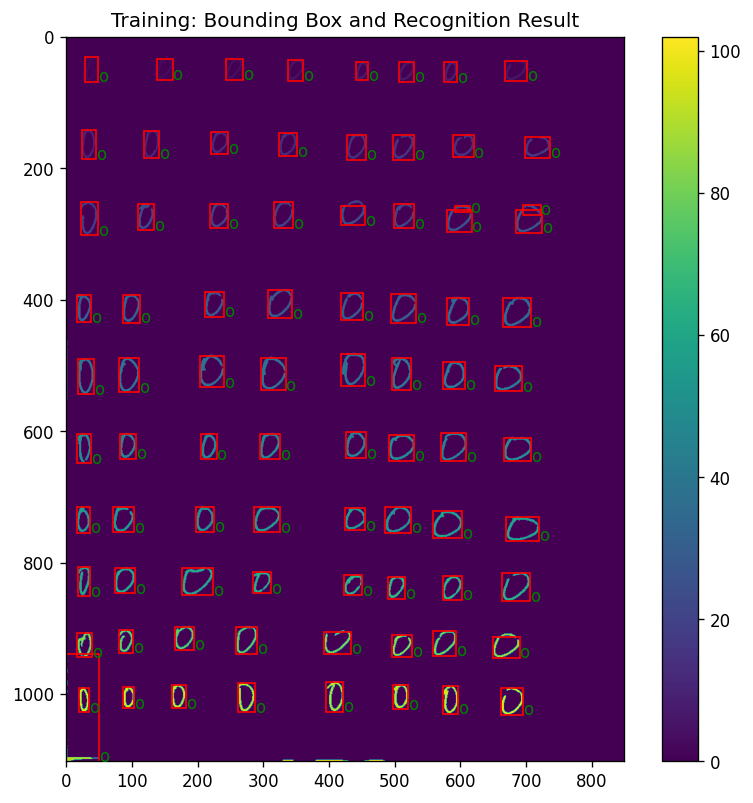

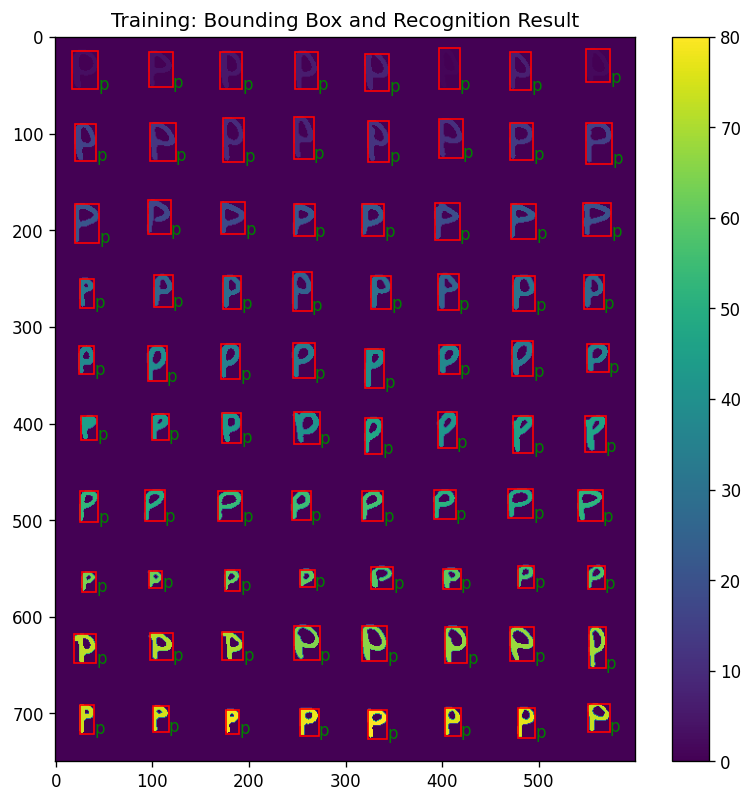

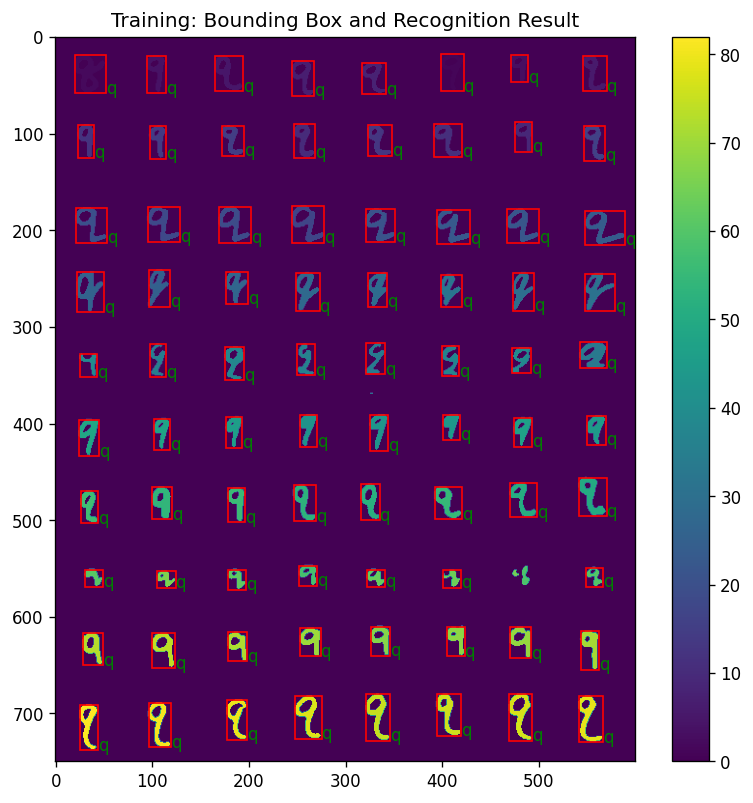

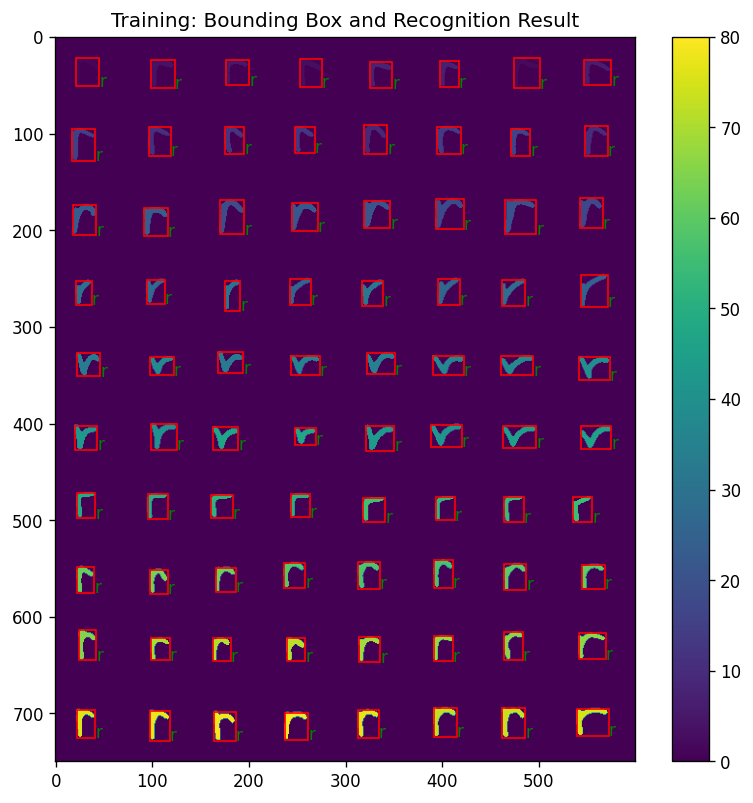

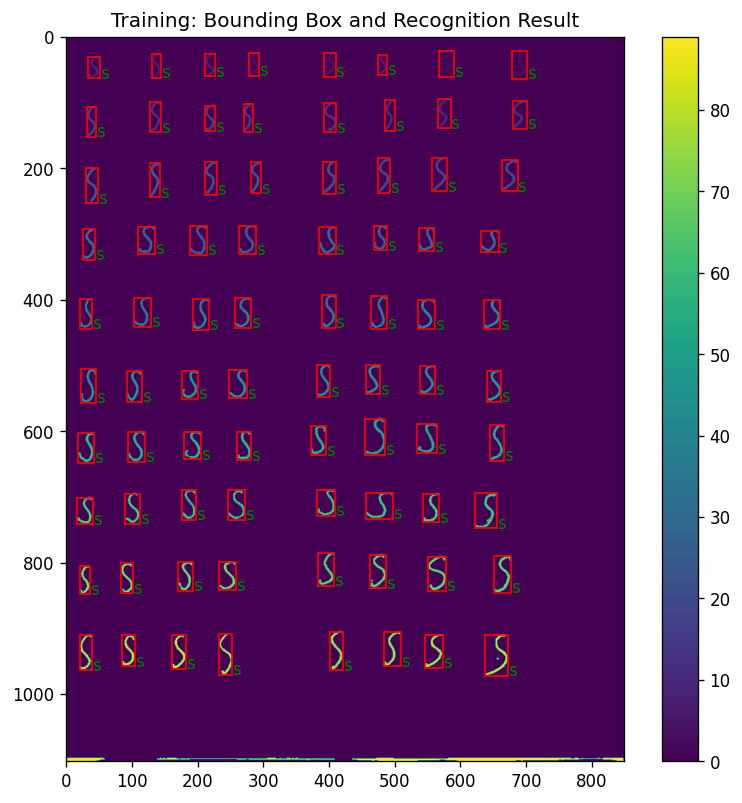

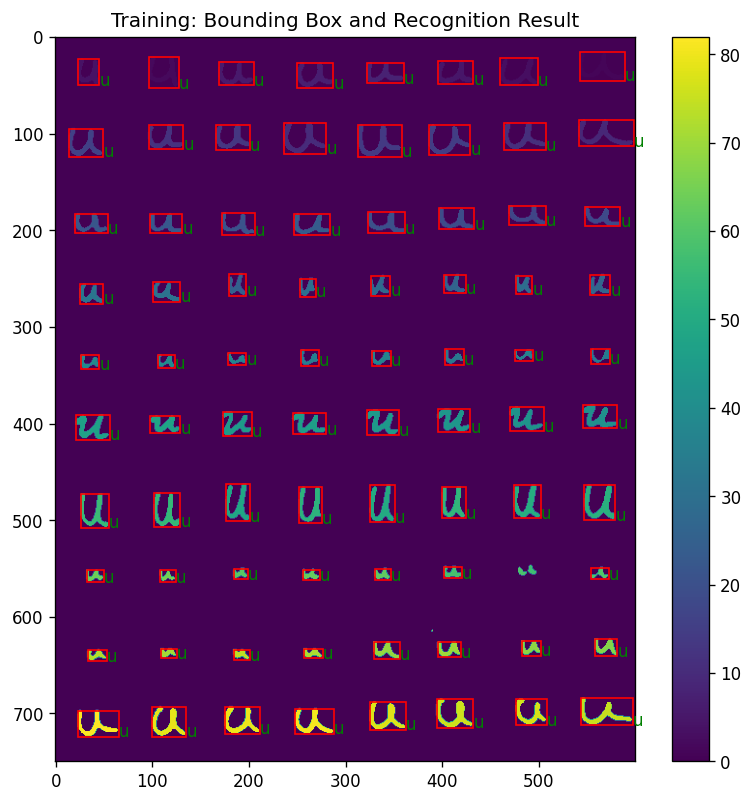

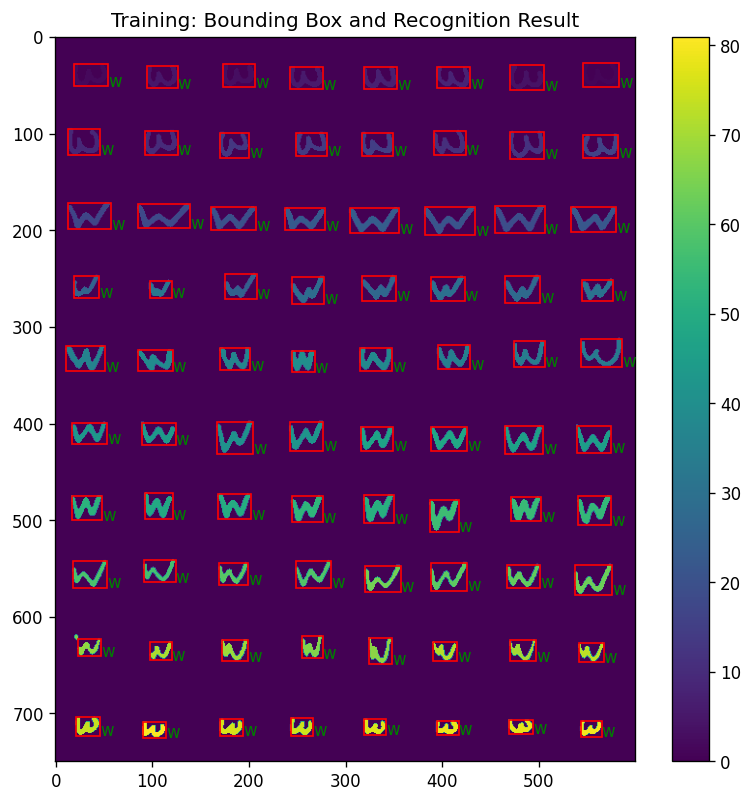

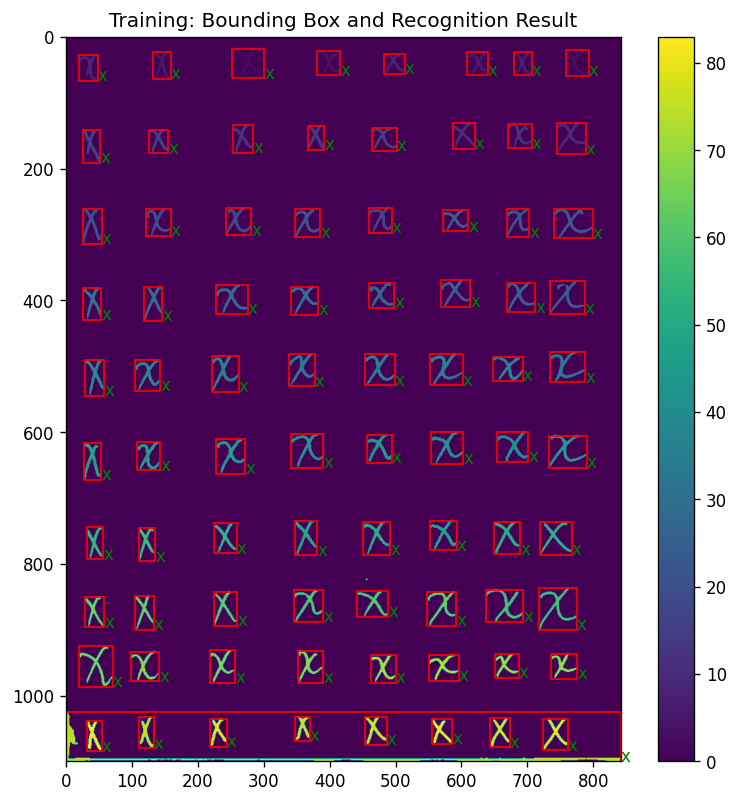

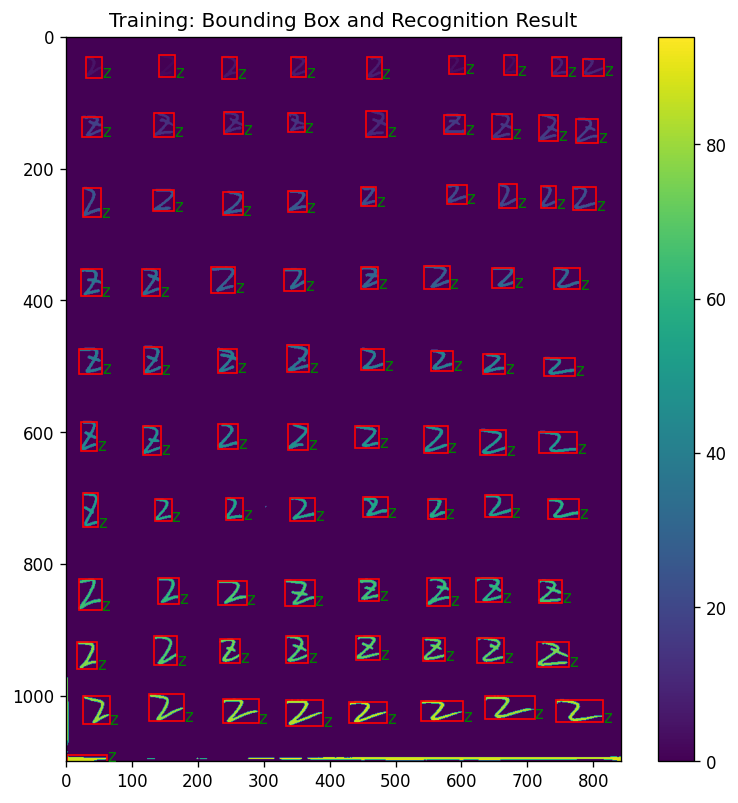

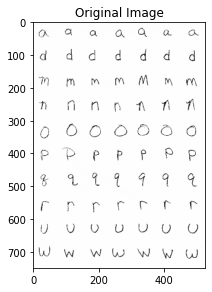

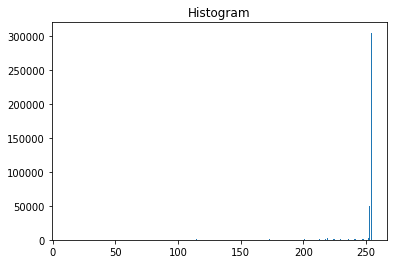

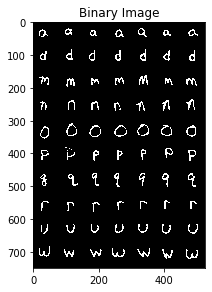

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


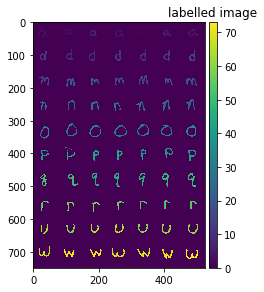

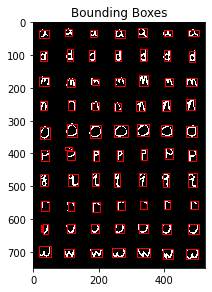

Number of components in testing image: 70
Testing recogition rate: 0.4857142857142857


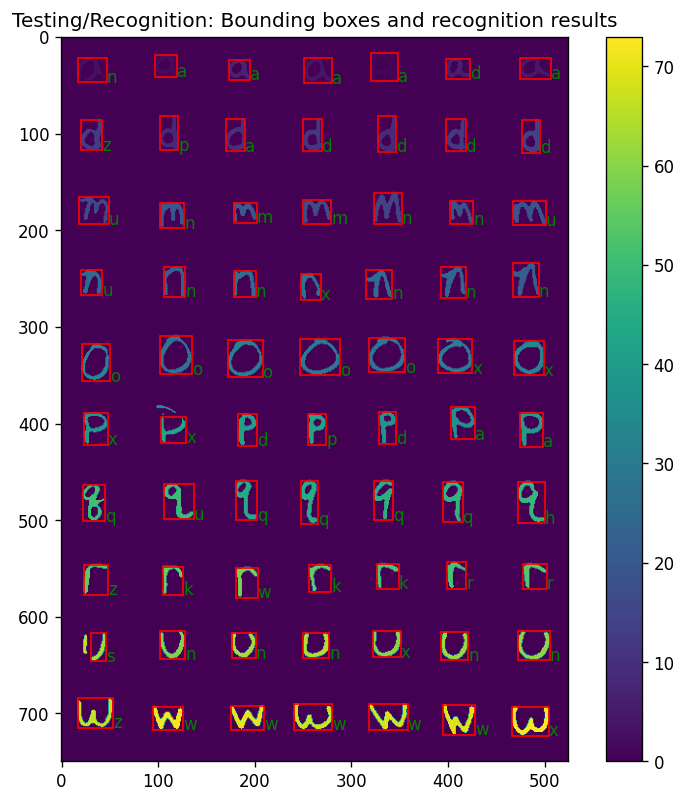

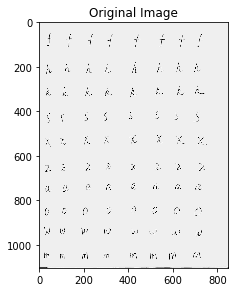

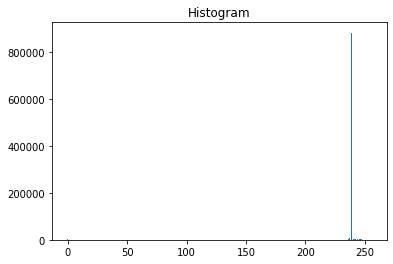

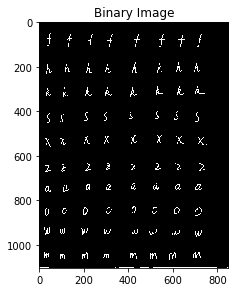

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


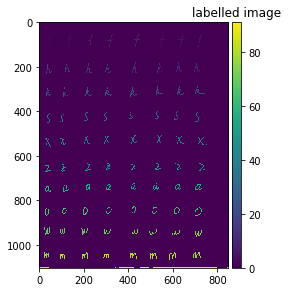

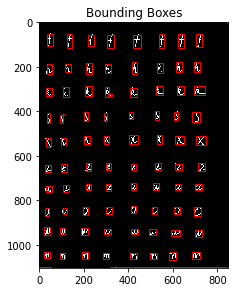

Number of components in testing image: 80
Testing recogition rate: 0.5375


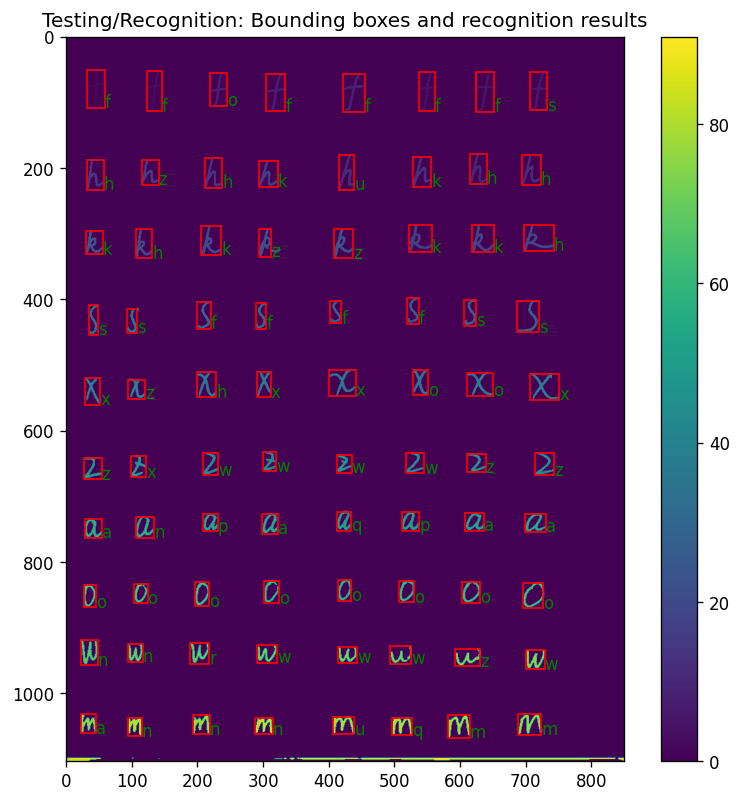

In [ ]:
# Your enhanced algorithm
# Processes one image, and adds the features of each character (bounding box) to the features list. 
# This function returns a list of size 2.
#   index 0 -> the img_label image with the connected components.
#   index 1 -> the bounding boxes that contain characters.
# img_name          <- Input: Name of the image to process
# features_list     <- Output: Features for each character are added to this list
# show_plots        <- Input: Boolean to specify whether plots are printed
# binary_threshold  <- Input: Specifies the threshold for binarizing the image
# min_bbox_height   <- Input: Specifies the minimum height of a bounding box
# min_bbox_width    <- Input: Specifies the minimum width of a bounding box
# Returns [img_label, [bounding  boxes]]. 
import cv2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
def process(img_name, features_list,
            show_plots=True, binary_threshold=200, 
            min_bbox_height=10, min_bbox_width=10):

    # Read the image
    img = None
    
    # YOUR CODE HERE
    img = io.imread(f'{images_path}/{img_name}')

    # Visualize read image
    if show_plots:
        # YOUR CODE HERE
        visualize(img, 'Original Image')

    # Visualize the histogram
    if show_plots:
        # YOUR CODE HERE
        hist = exposure.histogram(img)
        plt.bar(hist[1], hist[0])
        plt.title('Histogram')
        plt.show()

    # Binarize the image
    img_binary = None
    ksize = (5, 5)  # kernel size
    sigmaX = 0      # standard deviation in X direction
    sigmaY = 0      # standard deviation in Y direction
    img_blur = cv2.GaussianBlur(img, ksize, sigmaX, sigmaY)
    # YOUR CODE HERE
    img_binary = (img_blur < binary_threshold).astype(np.double)

  
    
    # Visualize the binary image
    if show_plots:
        # YOUR CODE HERE
        visualize(img_binary, 'Binary Image')

    # Labelling connected components
    img_label = None
    # YOUR CODE HERE
    img_label = label(img_binary, background=0)
    
    # Visualize the labeled image
    if show_plots:
        # YOUR CODE HERE
        visualize(img_label,'labelled image')

    # Extracting components
    regions = regionprops(img_label)
    count_features = 0
    bounding_box_list = list()
    
    # YOUR CODE HERE
    count_features=np.amax(img_label)
    regions = regionprops(img_label)
    for props in regions:
      minr, minc, maxr, maxc = props.bbox
      if ((maxc - minc < min_bbox_width) or (maxr - minr < min_bbox_height)):
            continue
      bounding_box_list.append(props.bbox)
      roi = img_binary[minr:maxr, minc:maxc]
      m = moments(roi)
      cc = m[0, 1] / m[0, 0]
      cr = m[1, 0] / m[0, 0]
      center = (cr, cc)
      mu = moments_central(roi, center)
      nu = moments_normalized(mu)
      hu = moments_hu(nu)
      features_list.append(hu)


    
    
    # Visualize the binary image with boxes
    if show_plots:
        # YOUR CODE HERE
        io.imshow(img_binary)
        ax = plt.gca()
        for props in regions:
          minr, minc, maxr, maxc = props.bbox
          ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor = 'red', linewidth = 1))
        ax.set_title('Bounding Boxes')
        io.show()

    return [img_label, bounding_box_list]
# Perform Training / Recogition
# training_db       <- Input: The array of features calculated during processing. Not normalized.
# class_label_array <- Input: array of character names that correspond with each row in the training_db
# region_info       <- Input: List of [img_label, [bounding boxes for that image]]
def training_recognition(training_db, class_label_array, region_info):
    # Normalize the training features
    normalized_training_db = None
    # YOUR CODE HERE
    # process_training_data(training_db, class_label_array, show_plots=False, binary_threshold=205)
    training_db=np.array(training_db)
    class_label_array=np.array(class_label_array)
    ft_means = np.mean(training_db, axis=0)
    ft_sds   = np.std(training_db, axis=0)
    normalized_training_db = (training_db - ft_means) / ft_sds
    # print(len(training_db))
    
    
    # The Distance Matrix
    distance_matrix = None
    # YOUR CODE HERE
    distance_matrix = cdist(normalized_training_db, normalized_training_db)
    visualize(distance_matrix, "Training: Distance Matrix", enlarge=True)

    # Sort each row in the distance matrix.
    sorted_rows = None
    # YOUR CODE HERE
    sorted_rows = np.argsort(distance_matrix, axis=1)
    
    # The first column contains the indexes of the characters themselves
    # The second column contains the indexes of the predictions
    # Associate the first_column_indexes with the class labels
    # Associate the second_column_indexes with the class labels
    first_column_indexes = None
    second_column_indexes = None
    Ytrue = None
    Ypred = None   
    
    # YOUR CODE HERE
    first_column_indexes = sorted_rows[:, 0]
    second_column_indexes = sorted_rows[:,1]
    Ytrue = class_label_array[first_column_indexes]
    Ypred=class_label_array[second_column_indexes]



    # Confusion Matrix
    confM = None
    # YOUR CODE HERE
    confM = better_confusion_matrix(Ytrue, Ypred, img_title='Training/Recognition: Confusion Matrix')

    # Recognition Rate / Crosschecking
    recognition_rate = None
    # YOUR CODE HERE
    correct = 0
    total = len(Ytrue)
    for true, pred in zip(Ytrue, Ypred):
      if true == pred:
        correct += 1

    recognition_rate = correct / total
    print(f'Training recognition rate: {recognition_rate}')

    # Draw the bounding boxes and recognition results for each test image (10 images in total)
    prediction_offset = 0 # you can use prediction_offset to fetch the data in all images
    for image_region_info in region_info:
        img_label = None
        bbox_list = None
        prediction_subarray = Ypred[prediction_offset:prediction_offset+len(image_region_info[1])]
        # YOUR CODE HERE

        # for img_label,bbox_list in image_region_info:
        bbox_result(image_region_info[0], image_region_info[1], prediction_subarray, img_title='Training: Bounding Box and Recognition Result')
        
    return recognition_rate
# Performs Testing / Recognition
# img_name          <- Input: Name of the testing image
# training_db       <- Input: The array of features calculated during processing. Not normalized.
# class_label_array <- Input: array of character names that correspond with each row in the training_db
# show_plots        <- Input: Boolean to specify whether plots are printed
# binary_threshold  <- Input: Specifies the threshold for binarizing the image
# min_bbox_height   <- Input: Specifies the minimum height of a bounding box
# min_bbox_width    <- Input: Specifies the minimum width of a bounding box
def testing_recognition(img_name, training_db, class_label_array,
         show_plots=True, binary_threshold=200, bounding_row_threshold=10, bounding_col_threshold=10):
  
    # Process the testing data using the same function as the training data
    # Unpack values returned from process into variables "img_label" and "bboxes"
    testing_ft_array = None
    img_label, bboxes = None, None
    # YOUR CODE HERE
    testing_ft_array=[]
    img_label, bboxes = process(img_name, testing_ft_array,
            show_plots=True, binary_threshold=binary_threshold, 
            min_bbox_height=bounding_row_threshold, min_bbox_width=bounding_col_threshold)
    
    # Normalize testing data with same parameters as training data. 
    normalized_training_ft = None
    normalized_testing_ft = None
   
    testing_ft_array=np.array(testing_ft_array)
    training_db=np.array(training_db)
    ft_means = np.mean(training_db, axis=0)
    ft_sds   = np.std(training_db, axis=0)
    normalized_training_ft=(training_db-ft_means)/ft_sds
    normalized_testing_ft = (testing_ft_array - ft_means) / ft_sds


    # Get the predictions
    Ypred = None
    # YOUR CODE HERE
    distance_matrix = cdist(normalized_testing_ft,normalized_training_ft)
    sorted_rows = np.argsort(distance_matrix, axis=1)
    first_column_indexes = sorted_rows[:, 0]
    second_column_indexes = sorted_rows[:,1]
    # print(sorted_rows)
    Ypred = class_label_array[first_column_indexes]
    # Ypred = distance_matrix[first_column_indexes]


    # Ytrue = class_label_array[first_column_indexes]
    # Ytrue=class_label_array[second_column_indexes]



    # Get the groundtruth locations and classes
    test_label_path = f'{materials_path}/{os.path.basename(img_name).split(".")[0]}_gt.pkl'
    pkl_file = open(test_label_path, 'rb')
    mydict = pickle.load(pkl_file, encoding='latin1')
    pkl_file.close()
    gt_classes = mydict['classes'] # n x 1 ndarray
    gt_locations = mydict['locations'] # n x 2 ndarray
    print(len(gt_locations),len(bboxes),len(gt_classes),len(Ypred),gt_classes)


    # Calculate recognition rate
    testing_recognition_rate = None
    # YOUR CODE HERE
    correct = 0
    total = len(gt_classes)
    import copy
    gt_locations_storage = copy.deepcopy(gt_locations)
    gt_classes_storage = copy.deepcopy(gt_classes)
    gt_locations = sorted(gt_locations, key=lambda x: x[1])
    gt_locations = [tuple(elem) for elem in gt_locations]
    gt_locations_storage = [tuple(elem) for elem in gt_locations_storage]
    for classy in range(gt_classes.shape[0]):
        loc_index = gt_locations_storage.index(gt_locations[classy])
        gt_classes[classy] = gt_classes_storage[loc_index]
    for true, pred in zip(gt_classes, Ypred):
        if true == pred:
            correct += 1


    testing_recognition_rate = correct / total
    
    print(f'Number of components in testing image: {len(bboxes)}')
    print(f'Testing recogition rate: {testing_recognition_rate}')

    bbox_result(img_label, bboxes, Ypred, img_title='Testing/Recognition: Bounding boxes and recognition results')
    
    return testing_recognition_rate
def pipeline(img_name_list, show_all_plots,
             binary_threshold, min_bbox_height, min_bbox_width):
  
    features_db_list = []
    classes_list     = [] # Contains the character names that correspond with each row in the features_db

    # Build the features database (processing and training) using function `process_training_data`
    region_info = None
    # YOUR CODE HERE
    region_info = process_training_data(features_db_list, classes_list, show_plots=show_all_plots, binary_threshold=binary_threshold)

    assert(len(region_info) == 16) # There are 16 characters. 

    features_db_array = np.asarray(features_db_list)
    classes_array     = np.asarray(classes_list)

    # Run training using function `training_recognition`
    train_recognition_rate = 0
    # YOUR CODE HERE
    train_recognition_rate=training_recognition(features_db_list, classes_list, region_info)

    # Run testing/recognition using function `testing_recognition`
    test_recognition_rate_1 = 0
    test_recognition_rate_2 = 0
    # YOUR CODE HERE
    test_recognition_rate_1=testing_recognition(img_name_list[0], features_db_array, classes_array,
         show_plots=show_all_plots, binary_threshold=binary_threshold, bounding_row_threshold=min_bbox_height, bounding_col_threshold=min_bbox_width)
    test_recognition_rate_2=testing_recognition(img_name_list[1], features_db_array, classes_array,
         show_plots=show_all_plots, binary_threshold=binary_threshold, bounding_row_threshold=min_bbox_height, bounding_col_threshold=min_bbox_width)
    
    return train_recognition_rate, test_recognition_rate_1, test_recognition_rate_2

# train_recognition_rate, test_recognition_rate_1, test_recognition_rate_2 = pipeline(['test1.bmp', 'test2.bmp'], False, 205, 10, 10)




# please provide your enhanced_train_recognition_rate, enhanced_test_recognition_rate_1, enhanced_test_recognition_rate_2 from your `enhanced_pipeline`
# enhanced_train_recognition_rate, enhanced_test_recognition_rate_1, enhanced_test_recognition_rate_2 = enhanced_pipeline(['test1.bmp', 'test2.bmp'], False, 205, 10, 10)
enhanced_train_recognition_rate, enhanced_test_recognition_rate_1, enhanced_test_recognition_rate_2 = pipeline(['test1.bmp', 'test2.bmp'], False, 190, 15, 15)
print("End of Guassian")
print("Combined Model")


def training_recognition(training_db, class_label_array, region_info):
    normalized_training_db = (training_db - np.mean(training_db, axis=0)) / np.std(training_db, axis=0)
    clf = DecisionTreeClassifier()
    clf.fit(normalized_training_db, class_label_array)
    Ypred = clf.predict(normalized_training_db)
    Ytrue = class_label_array
    confusionMatrix = confusion_matrix(Ytrue, Ypred)
    print(f'Training confusion matrix:\n{confusionMatrix}')
    enhanced_recognition_rate = clf.score(normalized_training_db, class_label_array)
    print(f'Training recognition rate: {enhanced_recognition_rate}')
    prediction_offset = 0 # you can use prediction_offset to fetch the data in all images
    for image_region_info in region_info:
        img_label = image_region_info[0]
        bbox_list = image_region_info[1]
        prediction_subarray = Ypred[prediction_offset:prediction_offset+len(bbox_list)]
        prediction_offset += len(bbox_list)

        bbox_result(img_label, bbox_list, prediction_subarray, img_title='Training: Bounding Box and Recognition Result')
        
    return enhanced_recognition_rate
def testing_recognition(img_name, training_db, class_label_array,
         show_plots=True, binary_threshold=200, bounding_row_threshold=10, bounding_col_threshold=10):

    testing_ft_array = []
    process_output = process(img_name, testing_ft_array, show_plots=True, binary_threshold=binary_threshold, min_bbox_height=bounding_row_threshold, min_bbox_width=bounding_col_threshold)
    img_label, bboxes = process_output[0], process_output[1] 
    normalized_training_ft = None
    normalized_testing_ft = None

    ft_means = np.mean(training_db, axis=0)
    ft_sds = np.std(training_db, axis=0)
    normalized_training_ft = (training_db - ft_means) / ft_sds

    normalized_testing_ft = (np.asarray(testing_ft_array) - ft_means) / ft_sds
    Ypred = None
    clf = DecisionTreeClassifier()
    clf.fit(normalized_training_ft, class_label_array)

    Ypred = clf.predict(normalized_testing_ft)
    test_label_path = f'{materials_path}/{os.path.basename(img_name).split(".")[0]}_gt.pkl'
    pkl_file = open(test_label_path, 'rb')
    mydict = pickle.load(pkl_file, encoding='latin1')
    pkl_file.close()
    gt_classes = mydict['classes'] # n x 1 ndarray
    gt_locations = mydict['locations'] # n x 2 ndarray
    enhanced_testing_recognition_rate = None
    correct = 0
    total = len(gt_classes)
    import copy
    gt_locations_storage = copy.deepcopy(gt_locations)
    gt_classes_storage = copy.deepcopy(gt_classes)
    gt_locations = sorted(gt_locations, key=lambda x: x[1])
    gt_locations = [tuple(elem) for elem in gt_locations]
    gt_locations_storage = [tuple(elem) for elem in gt_locations_storage]
    for classy in range(gt_classes.shape[0]):
        loc_index = gt_locations_storage.index(gt_locations[classy])
        gt_classes[classy] = gt_classes_storage[loc_index]
    for true, pred in zip(gt_classes, Ypred):
        if true == pred:
            correct += 1
    enhanced_testing_recognition_rate = correct / total

    print(f'Number of components in testing image: {len(bboxes)}')
    print(f'Testing recogition rate: {enhanced_testing_recognition_rate}')

    bbox_result(img_label, bboxes, Ypred, img_title='Testing/Recognition: Bounding boxes and recognition results')
    
    return enhanced_testing_recognition_rate
def pipeline(img_name_list, show_all_plots,
                      binary_threshold, min_bbox_height, min_bbox_width):
  
    features_db_list = []
    classes_list = [] # Contains the character names that correspond with each row in the features_db

    # Build the features database (processing and training) using function `process_training_data`
    region_info = None
    # YOUR CODE HERE
    region_info = process_training_data(features_db_list, classes_list, show_plots=False, binary_threshold=205)
    assert(len(region_info) == 16) # There are 16 characters. 

    features_db_array = np.asarray(features_db_list)
    classes_array = np.asarray(classes_list)

    # Run training using function `training_recognition`
    train_recognition_rate = 0
    # YOUR CODE HERE
    train_recognition_rate = training_recognition(features_db_array, classes_array, region_info)
  
    # Run testing/recognition using function `testing_recognition`
    test_recognition_rate_1 = 0
    test_recognition_rate_2 = 0
    # YOUR CODE HERE
    # pass
    test_recognition_rate_1 = testing_recognition(img_name_list[0], features_db_array, classes_array,
                                                           show_plots=True, binary_threshold=binary_threshold, bounding_row_threshold=min_bbox_height, bounding_col_threshold=min_bbox_width)
    test_recognition_rate_2 = testing_recognition(img_name_list[1], features_db_array, classes_array,
                                                           show_plots=True, binary_threshold=binary_threshold, bounding_row_threshold=min_bbox_height, bounding_col_threshold=min_bbox_width)
    

    return train_recognition_rate, test_recognition_rate_1, test_recognition_rate_2

enhanced_train_recognition_rate, enhanced_test_recognition_rate_1, enhanced_test_recognition_rate_2 = pipeline(['test1.bmp', 'test2.bmp'], False, 205, 10, 10)


In [ ]:
### Please do not modify this cell

assert enhanced_train_recognition_rate > train_recognition_rate
assert enhanced_test_recognition_rate_1 > test_recognition_rate_1
assert enhanced_test_recognition_rate_2 > test_recognition_rate_2